## Model Load

In [2]:
from utils import set_root
from loguru import logger
import numpy as np
import torch
from tqdm import tqdm
from pytorch_lightning import seed_everything
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/manni/physioex


In [3]:
%ls

LICENSE*
README.md*
__pycache__/
concept_labeling/
docs/
embedding_proto15_6612_shhs.npy
embeddings_mass_ssh_conv3d.npy
embeddings_mass_ssh_seqsleepnet.npy
example_records/
examples/
input_to_check.pt
label_to_check.pt
labels_mass_ssh_conv3d.npy
labels_mass_ssh_seqsleepnet.npy
labels_proto15_6612_shhs.npy
lightning_logs/
main.py*
mkdocs.yml*
models/
multi-source-domain.yaml*
my_experiment.yaml*
n3.png
old_models/
pca_2d.png
pca_2d_white.png
physioex/
physioex.egg-info/
protoae6612_closest_corresponding_inputs.npy
protoae6612_closest_corresponding_labels.npy
protoae6612_closest_distances.npy
protoae6612_closest_embeddings.npy
protos/
requirements.txt*
setup.py*
shhs_to_mass_inv10000_concept_targets.npy
teacher_student.py*
teacherstudent.yaml*
temp/
wake.png


In [4]:
#from physioex.data import TimeDistributedModule, SleepEDF, Shhs, SleepMerged
from physioex.data.datamodule import PhysioExDataModule
from physioex.data import get_datasets

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.train.networks.utils.target_transform import get_mid_label

Seed set to 42
Seed set to 42


In [5]:
# importing
import numpy as np
from loguru import logger
import os
import math

from physioex.train.networks import config

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [6]:
import seaborn as sns
max_ = 3
min_ = -3

def plotTheSpectrogram(spectrogram_tensor, max, min):
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
    plt.figure(figsize=(5, 5))
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='viridis',vmin=-3, vmax=4)
    #plt.imshow(spectrogram_array, aspect='auto', origin='lower', cmap='coolwarm')
    sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True, vmax=max, vmin=min)
            
    #plt.colorbar(format='%+2.0f')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plotSpectrogram(ax, spectrogram_tensor, title, max, min, denorm=None, cut = None):
    if (denorm is not None):
        mean, std = denorm
        spectrogram_tensor = spectrogram_tensor * std + mean
        spectrogram_tensor = spectrogram_tensor.to(torch.double)
        spectrogram_tensor = 10**(spectrogram_tensor/20)
        cmap='Blues'
    else:
        cmap='coolwarm'

    if cut is not None:
        spectrogram_tensor = spectrogram_tensor[:, : cut]

    # spectrogram_tensor = spectrogram_tensor.unsqueeze(0)
    # spectrogram_tensor = torch.max_pool2d(spectrogram_tensor, kernel_size=(2, 1), stride=(2, 1))
    # spectrogram_tensor = spectrogram_tensor.squeeze(0)
    
    spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
   
    sns.heatmap(spectrogram_array, cmap=cmap, cbar=True, vmax=max, vmin=min, ax=ax,)

    ax.set_title(title)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.invert_yaxis()

# def plotSpectrogram(ax, spectrogram_tensor, title, max, min):
#     spectrogram_array = spectrogram_tensor.permute(1, 0).numpy()
    
#     sns.heatmap(spectrogram_array, cmap='coolwarm', cbar=True, vmax=max, vmin=min, ax=ax,)

#     ax.set_title(title)
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Frequency')
#     ax.invert_yaxis()

def plotSpectrograms(spectrograms, titles, max, min):
    n = len(spectrograms)
    fig, axes = plt.subplots(math.ceil(n/2), 2, figsize=(10, 5*math.ceil(n/2)))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms12(spectrograms, titles, max, min):
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min)

    plt.tight_layout()
    plt.show()

def plotSpectrograms20(spectrograms, titles, max, min, denorm=None, cut=None):
    fig, axes = plt.subplots(7, 3, figsize=(15, 35))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()

def plotSpectrograms15(spectrograms, titles, max, min, denorm=None, cut=None):
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()
    #fig.savefig('n3.png', dpi=300, transparent=True)

def plotSpectrograms6(spectrograms, titles, max, min, denorm=None, cut=None):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()

def plotSpectrograms3(spectrograms, titles, max, min, denorm=None, cut=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Esegui il plot per ogni spettrogramma
    for i, (ax, spectrogram) in enumerate(zip(axes.flatten(), spectrograms)):
        plotSpectrogram(ax, spectrogram, titles[i], max=max, min=min, denorm=denorm, cut=cut)

    plt.tight_layout()
    plt.show()

In [7]:
def get_single_file_path(directory):
    # Lista di tutti i file nella cartella
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Controlla che ci sia un solo file nella cartella
    if len(files) == 1:
        return os.path.join(directory, files[0])
    else:
        raise ValueError("La cartella non contiene esattamente un file.")

In [8]:
# model parameters
model_name1 = "protoae_seqsleepnet"
model_name2 = "protoae_seqsleepnet"
model_name3 = "protoae_seqsleepnet"


# load dataset and model
model = networks[model_name1]
# model2 = networks[model_name2]
# model3 = networks[model_name3]
# model4 = networks[model_name4]


In [9]:
checkpoint1 = get_single_file_path('models/protoae_seqsleepnet/protoae_ssn6611_mass_l3_eeg')
checkpoint2 = get_single_file_path('models/protoae_seqsleepnet/protoae_ssn6612_shhs_l3_eeg')
checkpoint3 = get_single_file_path('models/protoae_seqsleepnet/protoae_6612_alldata_l3_eeg')

model_config_name = ["mass_6611", "shhs_6612", "alldata_6612"]

In [10]:
# dataset
picks = ["EEG"]
fold = 0
sequence_length = 3

# dataloader
batch_size = 128

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dict1 = {"batch_size": 128}

In [11]:
input_transform = model["input_transform"]
target_transform = model["target_transform"]

dataset = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=input_transform,
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=target_transform,
    data_folder = "/mnt/guido-data"
)

Selected fold for dataset 0: 0
Selected fold for dataset 0: 0


In [12]:
scaling_mean = dataset.dataset.scaling[0][0].squeeze()
scaling_std = dataset.dataset.scaling[0][1].squeeze()

In [13]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model1 = load_pretrained_model(
    name=model_name1,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint1,
    extra_params = dict1
).eval()


In [14]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model2 = load_pretrained_model(
    name=model_name2,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint2,
    extra_params = dict1
).eval()

In [15]:
dict1 = {"batch_size": 128, "n_prototypes": 15}

model3 = load_pretrained_model(
    name=model_name3,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "mse",
    ckpt_path=checkpoint3,
    extra_params = dict1
).eval()

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.3.2


### Concept Activation Assignment

In [16]:
dataloder = dataset.test_dataloader()
num = len(dataloder)*batch_size
emb_dim = 32
model = model2
print(checkpoint2)
prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()


models/protoae_seqsleepnet/protoae_ssn6612_shhs_l3_eeg/fold=-1-epoch=7-step=231968-val_loss=6.80.ckpt


In [17]:
embeddings_array = np.empty((num, emb_dim))
labels_array = np.empty((num))

epoch_to_save = int((model.nn.L-1)/2)
print("epoch selected: ",epoch_to_save)
print(embeddings_array.shape)
print(labels_array.shape)

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        #print(sleep_stages[labels[batch].item()])
        embedding = model.nn.encode(inputs.to(device)).permute(1, 0, 2)
        embeddings_array[i*batch_size : i*batch_size+inputs.size(0)] = embedding[epoch_to_save].cpu().numpy()
        labels_array[i*batch_size : i*batch_size+inputs.size(0)] = labels[:, epoch_to_save].cpu().numpy()

        if i == len(dataloder)-1:
            n_last_batch = inputs.size(0)


epoch selected:  1
(10752, 32)
(10752,)


100%|██████████| 84/84 [00:01<00:00, 63.73it/s]


In [18]:
first_empty_element = len(embeddings_array)-batch_size+n_last_batch
embeddings_array_ref = embeddings_array[0:first_empty_element]
labels_array_ref = labels_array[0:first_empty_element]

In [21]:
inputs.shape

torch.Size([106, 3, 1, 29, 129])

In [22]:
labels.shape

torch.Size([106, 3])

In [20]:
model = model2
central_epoch = int((model.nn.L-1)/2)
def inputs_to_embeddings(inputs):
    with torch.no_grad():
        embeddings = model.nn.encode(inputs.to(device)).permute(1, 0, 2)
        return embeddings[central_epoch].cpu().numpy()

prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()
def concept_labeling(embeddings, lambda_fun):
    distances = np.linalg.norm(embeddings[:, None, :] - prototypes[None, :, :], axis=2)
    closest_prototypes = np.argmin(distances, axis=1)
    concepts_target = lambda_fun(distances)
    return closest_prototypes, distances, concepts_target

In [23]:
print(inputs.shape)
print(labels.shape)
idx = 1
print(labels[idx])
embeddings = inputs_to_embeddings(inputs)
print(embeddings.shape)
lambda_fun1 = lambda d: 1 / (100**d)
lambda_fun2 = lambda d: 1 / (10**d)
lambda_fun3 = lambda d: 1 / (1 + 5**(10*(d-0.30)))


closest_prototypes, distances, concepts_target = concept_labeling(embeddings, lambda_fun3)
print(closest_prototypes.shape)
print(distances.shape)
print(concepts_target.shape)
print(closest_prototypes[idx])
for i in range(15):
    print("concept:",i,"\tactivation:", np.round(concepts_target[idx][i], 2), "\tdistance:", np.round(distances[idx][i], 2))
    

torch.Size([106, 3, 1, 29, 129])
torch.Size([106, 3])
tensor([2, 0, 1])
(106, 32)
(106,)
(106, 15)
(106, 15)
13
concept: 0 	activation: 0.64 	distance: 0.27
concept: 1 	activation: 0.02 	distance: 0.55
concept: 2 	activation: 0.0 	distance: 0.92
concept: 3 	activation: 0.11 	distance: 0.43
concept: 4 	activation: 0.0 	distance: 0.69
concept: 5 	activation: 0.01 	distance: 0.63
concept: 6 	activation: 0.27 	distance: 0.36
concept: 7 	activation: 0.54 	distance: 0.29
concept: 8 	activation: 0.0 	distance: 0.79
concept: 9 	activation: 0.03 	distance: 0.52
concept: 10 	activation: 0.0 	distance: 0.87
concept: 11 	activation: 0.02 	distance: 0.53
concept: 12 	activation: 0.0 	distance: 0.97
concept: 13 	activation: 0.84 	distance: 0.2
concept: 14 	activation: 0.27 	distance: 0.36


In [261]:
dataset = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=input_transform,
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=target_transform,
    data_folder = "/mnt/guido-data"
)

Selected fold for dataset 0: 0


In [264]:
len(dataloader_to_label), len(dataset_to_label), 228470/128

(1785, 228470, 1784.921875)

In [294]:
x = 28470

In [295]:
data, labels = dataset_to_label.__getitem__(28470)
print(data[0][0][0][0])
print(labels[0])

tensor(2.2626)
tensor(0)


In [299]:
math.floor(x/128), x%128

(222, 54)

#### labeling loop

In [60]:
from physioex.data.dataset import PhysioExDataset
from torch.utils.data import DataLoader

def label_dataset(model, dataset=["mass"], lambda_fun= lambda d: 1/(10000**d), batch_size=128):
    central_epoch = int((model.nn.L-1)/2)
    
    dataset_to_label = PhysioExDataset(
        datasets = dataset,
        versions = None,
        preprocessing=input_transform,
        selected_channels=["EEG"],
        sequence_length = 3,
        target_transform=target_transform,
        data_folder = "/mnt/guido-data"
    )

    concepts_target_array = np.zeros((len(dataset_to_label), 15))
    distances_array = np.zeros((len(dataset_to_label), 15))

    dataloader_to_label = DataLoader(dataset_to_label, batch_size, sampler=None)
    with torch.no_grad():
        for batch_idx, data in tqdm(enumerate(dataloader_to_label), total=len(dataloader_to_label)):
            inputs, _ = data
            current_batch_size = inputs.size(0)
            embeddings = model.nn.encode(inputs.to(device)).permute(1, 0, 2)
            embeddings = embeddings[central_epoch].cpu().numpy()

            distances = np.linalg.norm(embeddings[:, None, :] - prototypes[None, :, :], axis=2)

            distances_array[batch_idx*batch_size : batch_idx*batch_size+current_batch_size] = distances
    
    min_value = distances_array.min()
    max_value = distances_array.max()

    # Apply min-max normalization
    n_distances_array = (distances_array - min_value) / (max_value - min_value)
    concepts_target_array = lambda_fun(n_distances_array)

    return concepts_target_array


In [61]:
model = model2
print(checkpoint2)
lambda_fun = lambda d: 1/(10000**d)

concepts_target_to_store = label_dataset(model=model, lambda_fun=lambda_fun, batch_size=1024)

models/protoae_seqsleepnet/protoae_ssn6612_shhs_l3_eeg/fold=-1-epoch=7-step=231968-val_loss=6.80.ckpt
Selected fold for dataset 0: 0


  0%|          | 0/224 [00:00<?, ?it/s]

100%|██████████| 224/224 [03:10<00:00,  1.18it/s]


In [223]:
#np.save("", concepts_target_to_store)

In [213]:
concepts_target_to_store[0]

array([0.95577817, 0.01831716, 0.00355882, 0.39400145, 0.02221925,
       0.01272809, 0.57205098, 0.08408811, 0.00613296, 0.02772421,
       0.01015453, 0.02192984, 0.00278239, 0.43357426, 0.10807417])

In [208]:
dataset_to_label = PhysioExDataset(
        datasets = ["mass"],
        versions = None,
        preprocessing=input_transform,
        selected_channels=["EEG"],
        sequence_length = 3,
        target_transform=target_transform,
        data_folder = "/mnt/guido-data"
    )

Selected fold for dataset 0: 0


In [210]:
len(dataset_to_label)

228470

In [209]:
idx = 1000

data, labels = dataset_to_label.__getitem__(idx)
print(labels)

for i in range(15):
    print("concept:",i,"\tconcept act:", np.round(concepts_target_to_store[idx][i], 2))

tensor([2, 3, 2])
concept: 0 	concept act: 0.01
concept: 1 	concept act: 0.1
concept: 2 	concept act: 0.47
concept: 3 	concept act: 0.0
concept: 4 	concept act: 0.0
concept: 5 	concept act: 0.27
concept: 6 	concept act: 0.0
concept: 7 	concept act: 0.02
concept: 8 	concept act: 0.89
concept: 9 	concept act: 0.02
concept: 10 	concept act: 0.0
concept: 11 	concept act: 0.04
concept: 12 	concept act: 0.34
concept: 13 	concept act: 0.01
concept: 14 	concept act: 0.01


In [222]:
concepts_target_to_store.max(), concepts_target_to_store.min()

(1.0, 0.0001)

In [226]:
condition_met = np.any(concepts_target_to_store > 0.90, axis=1)

rows_with_condition = np.sum(condition_met)

percentage = (rows_with_condition / concepts_target_to_store.shape[0]) * 100
percentage

9.843305466800894

In [269]:
x_values = np.arange(0.0, 1.01, 0.01)
def plot_percentage_values(array):
    percent_one_value = []
    percent_two_values = []
    percent_three_values = []
    percent_four_values = []
    percent_five_values = []

    for x in x_values:
        count_one_value = np.sum(np.any(array > x, axis=1))
        percent_one_value.append((count_one_value / len(array)) * 100)
        
        count_two_values = np.sum(np.sum(array > x, axis=1) >= 2)
        percent_two_values.append((count_two_values / len(array)) * 100)

        count_three_values = np.sum(np.sum(array > x, axis=1) >= 3)
        percent_three_values.append((count_three_values / len(array)) * 100)

        count_four_values = np.sum(np.sum(array > x, axis=1) >= 4)
        percent_four_values.append((count_four_values / len(array)) * 100)

        count_five_values = np.sum(np.sum(array > x, axis=1) >= 5)
        percent_five_values.append((count_five_values / len(array)) * 100)

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, percent_one_value, label='at least 1 activations > z', color='blue', linestyle='-', linewidth=2)
    plt.plot(x_values, percent_two_values, label='at least 2 activations > z', color='red', linestyle='-', linewidth=2)
    plt.plot(x_values, percent_three_values, label='at least 3 activations > z', color='green', linestyle='-', linewidth=2)
    plt.plot(x_values, percent_four_values, label='at least 4 activations > z', color='orange', linestyle='-', linewidth=2)
    plt.plot(x_values, percent_five_values, label='at least 5 activations > z', color='black', linestyle='-', linewidth=2)
    plt.xlabel('Concept Activation Target (z)')
    plt.ylabel('Percentage of points (%)')
    plt.title('Percentage of Points with at least N values > z in Concept Activation Targets')
    plt.legend()
    plt.grid(True)
    plt.show()

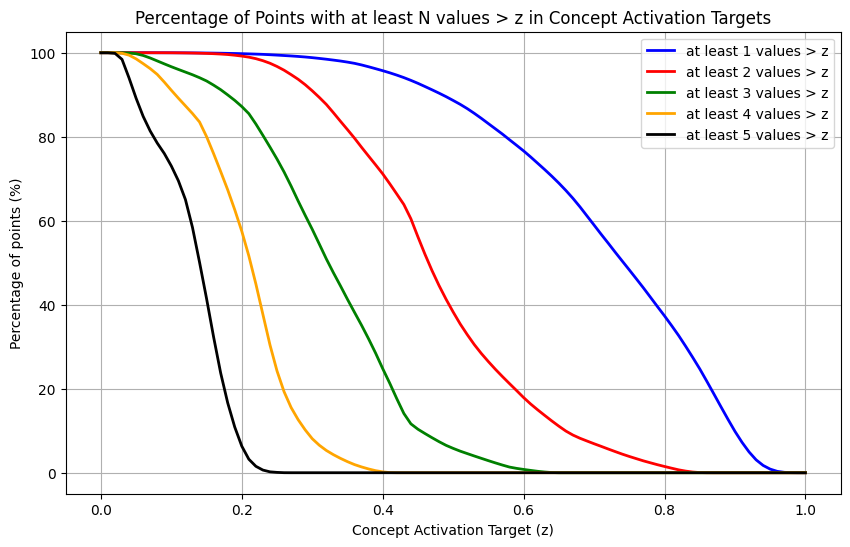

In [270]:
plot_percentage_values(concepts_target_to_store)

In [49]:
# embeddings_array_ref = np.load('embedding_proto15_6612_shhs.npy')
# labels_array_ref = np.load('labels_proto15_6612_shhs.npy')
# np.save('.npy', embeddings_array_ref)
# np.save('.npy', labels_array_ref)

In [271]:
#last significant element
embeddings_array[len(embeddings_array)-batch_size+n_last_batch - 1]

array([ 9.75810662e-02, -1.05817884e-01, -4.27419432e-02,  1.09821163e-01,
       -9.26102102e-02,  4.21138346e-01,  1.35121103e-02,  2.79605202e-02,
       -4.10173982e-01, -2.74274647e-01, -5.52270450e-02,  5.63735105e-02,
       -1.33505180e-01, -7.47849569e-02,  2.26688515e-02, -7.64370710e-02,
       -1.13538124e-01,  1.76077411e-01, -3.22249025e-01, -1.11490846e-01,
        1.75072104e-01, -2.72716850e-01, -3.92140225e-02,  3.82109098e-02,
        5.00164777e-02,  2.02789903e-01, -1.83956727e-01, -2.51508551e-04,
        1.13310114e-01,  2.04668760e-01,  1.02604426e-01, -3.70439589e-02])

In [25]:
embeddings_array[len(embeddings_array)-batch_size+n_last_batch]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [339]:
# embeddings_array_ref = embeddings_array[0:1201*128] #1200
# labels_array_ref = labels_array[0:1201*128]         #1200

In [27]:
first_empty_element = len(embeddings_array)-batch_size+n_last_batch
embeddings_array_ref = embeddings_array[0:first_empty_element]
labels_array_ref = labels_array[0:first_empty_element]

In [79]:
print("Awake:\t",np.sum(labels_array_ref == 0)/len(labels_array_ref)*100)
print("N1:\t", np.sum(labels_array_ref == 1)/len(labels_array_ref)*100)
print("N2:\t",np.sum(labels_array_ref == 2)/len(labels_array_ref)*100)
print("N3:\t",np.sum(labels_array_ref == 3)/len(labels_array_ref)*100)
print("REM:\t",np.sum(labels_array_ref == 4)/len(labels_array_ref)*100)

Awake:	 13.30321577771301
N1:	 8.412513358593218
N2:	 47.57553677256388
N3:	 13.219178082191782
REM:	 17.489556008938113


In [158]:
embeddings_array_ref.shape[0]

11880

In [24]:
block_size = 100000  # Puoi regolare questa dimensione in base alla tua RAM disponibile
num_embeddings = embeddings_array_ref.shape[0]

distance_results = []

for start in range(0, num_embeddings, block_size):
    end = min(start + block_size, num_embeddings)
    embeddings_block = embeddings_array_ref[start:end]
    distances_block = np.linalg.norm(embeddings_block[:, np.newaxis] - prototypes, axis=2)
    distance_results.append(distances_block)

distances = np.vstack(distance_results)

print(distances.shape)

(10730, 15)


In [25]:
media_colonne = np.mean(distances, axis=0)
std_colonne = np.std(distances, axis=0)
max_colonne = np.max(distances, axis=0)
min_colonne = np.min(distances, axis=0)

print("Media per ciascuna colonna:", media_colonne)
print("Deviazione standard per ciascuna colonna:", std_colonne)
print("Max per ciascuna colonna:", max_colonne)
print("Min per ciascuna colonna:", min_colonne)

Media per ciascuna colonna: [0.6434457  0.45535078 0.87496067 0.79071551 0.62479738 0.55382494
 0.72705198 0.4051118  0.73648248 0.43504617 0.78309322 0.41821531
 0.9366856  0.54229058 0.47994568]
Deviazione standard per ciascuna colonna: [0.28383972 0.28180085 0.35763888 0.31508218 0.3088225  0.30368226
 0.30722229 0.19873813 0.34773801 0.24827356 0.32490507 0.27891015
 0.35597617 0.24946086 0.24349059]
Max per ciascuna colonna: [1.192201   1.14470925 1.73594896 1.28395913 1.41249979 1.3358217
 1.24170806 0.98049826 1.58213035 1.02926234 1.58406051 1.09183736
 1.80015519 1.16219683 1.19951974]
Min per ciascuna colonna: [0.01416311 0.01548432 0.01833178 0.01388795 0.01676594 0.01603873
 0.01105154 0.01793857 0.01465398 0.01683471 0.01833183 0.01152132
 0.01587403 0.01758017 0.02327971]


In [26]:
# Min value: 0.008328100174974961
# Max value: 1.8521583173297296

In [30]:
min_value = distances.min()
max_value = distances.max()
print("Min value:", min_value)
print("Max value:", max_value)

# Apply min-max normalization
n_distances = (distances - min_value) / (max_value - min_value)

print("Min value:", n_distances.min())
print("Max value:", n_distances.max())

Min value: 0.011051541984844947
Max value: 1.8001551860753482
Min value: 0.0
Max value: 1.0


In [31]:
#train
# Min value: 0.008328100174974961
# Max value: 1.8521583173297296

In [32]:
#test
# Min value: 0.011051541984844947
# Max value: 1.8001551860753482

In [33]:
# val
# Min value: 0.012357132834510055
# Max value: 1.7904080545249121

In [34]:
def plot_concepts_target_distributions(concepts_target, y_max=None, file_path=None):
    num_colonne = concepts_target.shape[1]

    # Calcola statistiche delle colonne
    media_colonne = np.mean(concepts_target, axis=0)
    std_colonne = np.std(concepts_target, axis=0)
    max_colonne = np.max(concepts_target, axis=0)
    min_colonne = np.min(concepts_target, axis=0)

    print("Media per ciascuna prototipo:", media_colonne)
    print("Deviazione standard per ciascuna colonna:", std_colonne)
    print("Max per ciascuna colonna:", max_colonne)
    print("Min per ciascuna colonna:", min_colonne)
    
    # Trova i limiti globali per l'asse x
    x_min = np.min(concepts_target)
    x_max = np.max(concepts_target)

    # Crea una figura con sottotitoli per ogni colonna
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))  # Adatta il numero di righe e colonne
    #fig.suptitle('Values Distribution')

    # Appiattisci l'array di assi per facilitare l'iterazione
    axs = axs.flatten()

    for i in range(num_colonne):
        sns.histplot(concepts_target[:, i], kde=False, ax=axs[i], stat='percent', color='blue', alpha=0.7, bins=75)  # Modifica il valore di binwidth a seconda delle tue esigenze
        axs[i].set_title(f'Prototype {i}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        
        # Imposta gli stessi limiti x per ogni subplot
        axs[i].set_xlim(x_min, x_max)

        if(y_max is not None):
            axs[i].set_ylim(0, y_max)

    # Regola il layout per evitare sovrapposizioni
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if file_path is not None:
        plt.savefig(file_path, dpi=300)
    plt.show()

In [28]:
n_proto_dist_2_5 = (np.linalg.norm(prototypes[5] - prototypes[11]) - distances.min()) / (distances.max() - distances.min())
print(n_proto_dist_2_5)
print(1/(1000**n_proto_dist_2_5))

0.20646223961284405
0.24022227807944557


Media per ciascuna prototipo: [0.35346983 0.24833622 0.4828726  0.43578468 0.34304656 0.30337728
 0.40020065 0.22025569 0.40547173 0.23698718 0.43152429 0.22757975
 0.51737308 0.29693027 0.26208327]
Deviazione standard per ciascuna colonna: [0.15864912 0.15750952 0.19989836 0.17611175 0.17261297 0.16973989
 0.17171855 0.11108251 0.19436437 0.13876981 0.18160215 0.15589379
 0.19896901 0.13943343 0.13609641]
Max per ciascuna colonna: [0.66019063 0.63364563 0.96411263 0.71147783 0.78332424 0.74046585
 0.68786206 0.54186169 0.87813739 0.56911784 0.87921623 0.60409347
 1.         0.64342013 0.66428136]
Min per ciascuna colonna: [0.00173918 0.00247765 0.00406921 0.00158538 0.003194   0.00278753
 0.         0.00384943 0.00201355 0.00323244 0.00406924 0.00026258
 0.00269548 0.00364911 0.0068348 ]


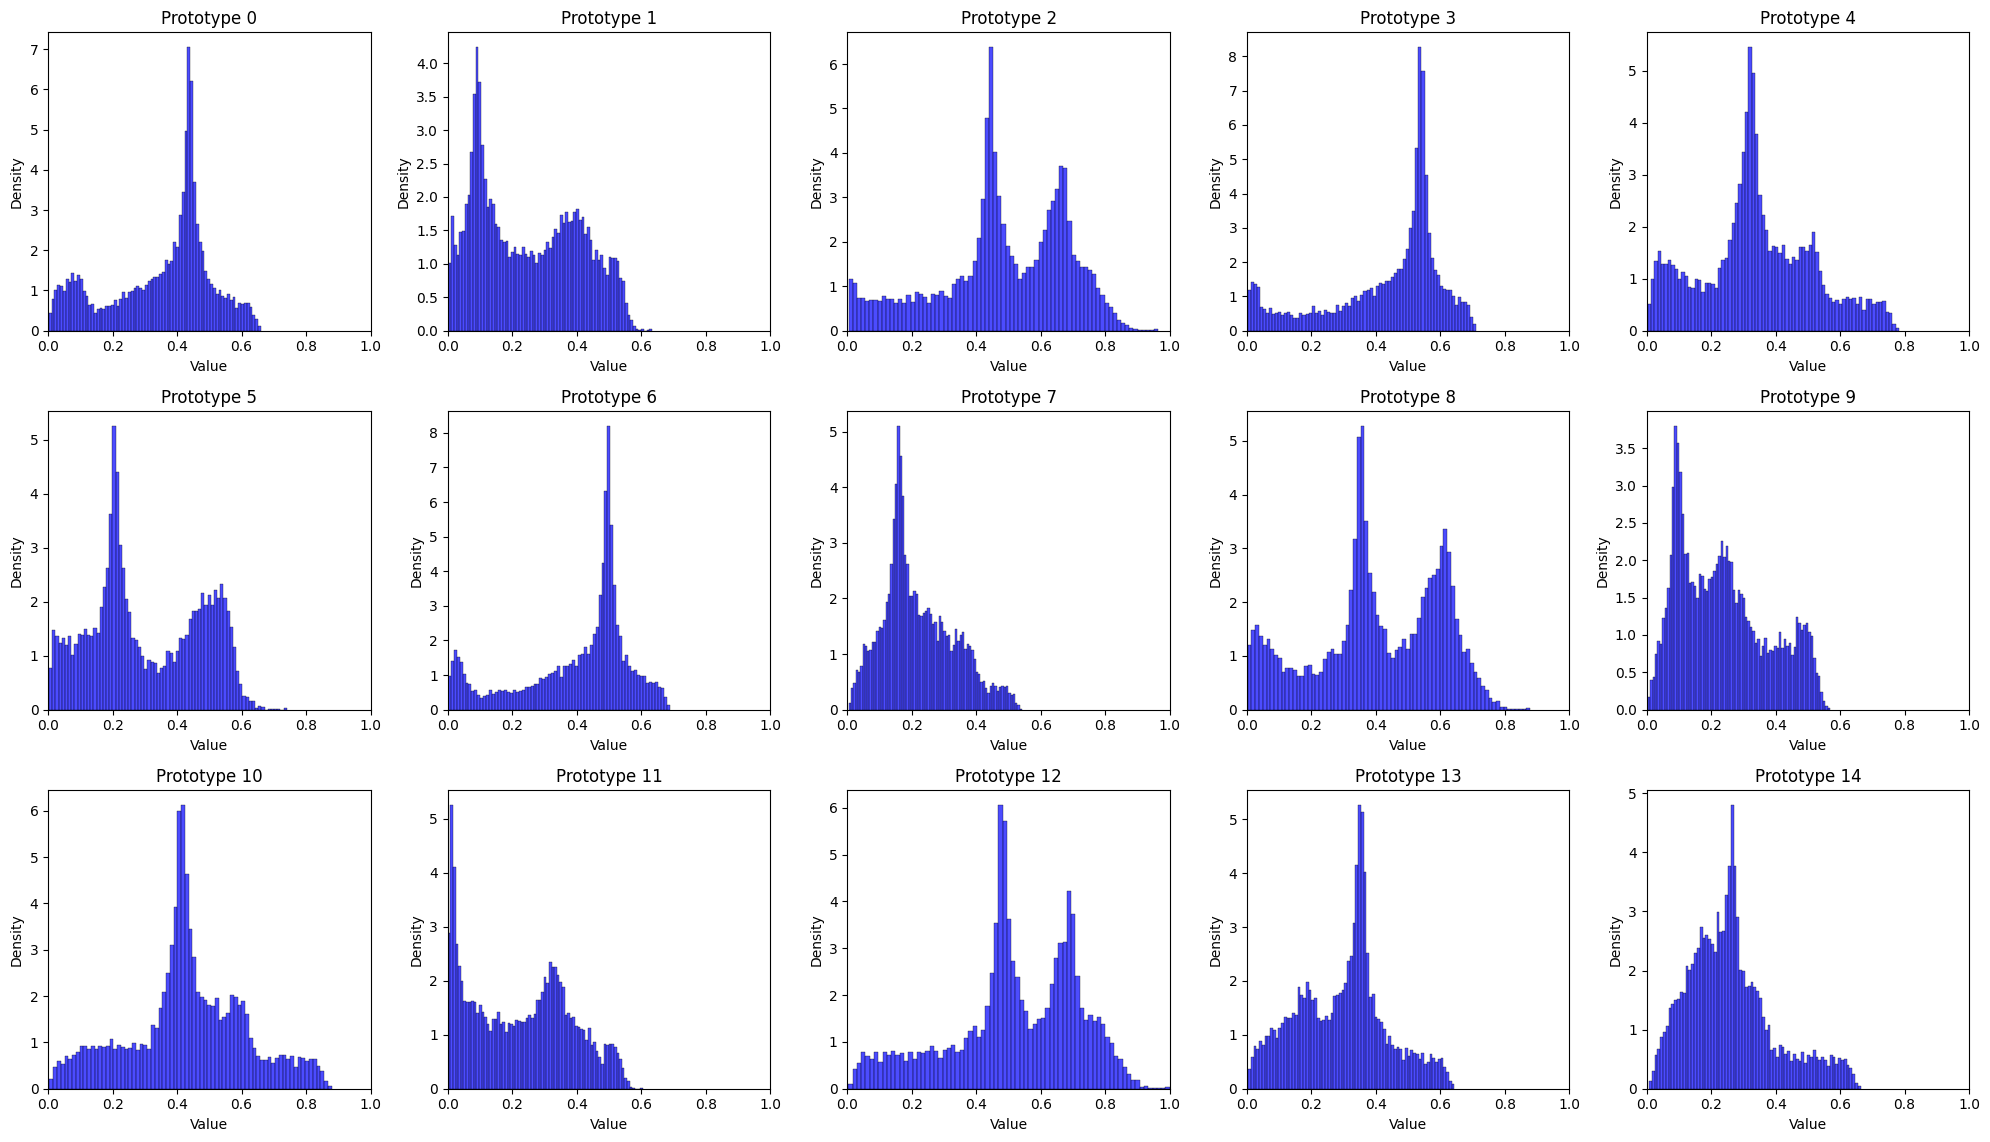

In [35]:
concepts_target = n_distances
plot_concepts_target_distributions(concepts_target, file_path="concept_labeling/shhs_to_mass/n_distances.png")

Media per ciascuna prototipo: [0.11563307 0.22270137 0.0955594  0.08348349 0.1207323  0.15322476
 0.10215982 0.19083709 0.11541355 0.20905444 0.08569721 0.28642458
 0.07983324 0.13434141 0.15794739]
Deviazione standard per ciascuna colonna: [0.19950062 0.23370798 0.21283067 0.18947207 0.17900595 0.19152272
 0.21235144 0.16342565 0.20512801 0.20001489 0.17758508 0.31754284
 0.19297054 0.17897988 0.16602958]
Max per ciascuna colonna: [0.97943131 0.98600636 0.98598733 0.99955144 0.98593028 0.99343174
 0.99096647 0.960815   0.99023303 0.98332509 0.98916004 1.
 0.99114312 0.97939552 0.96852278]
Min per ciascuna colonna: [0.00205056 0.00216904 0.0001382  0.00132475 0.00064781 0.00104847
 0.00162265 0.00563216 0.00030083 0.00299453 0.00027509 0.0024001
 0.0001     0.00232768 0.00188872]


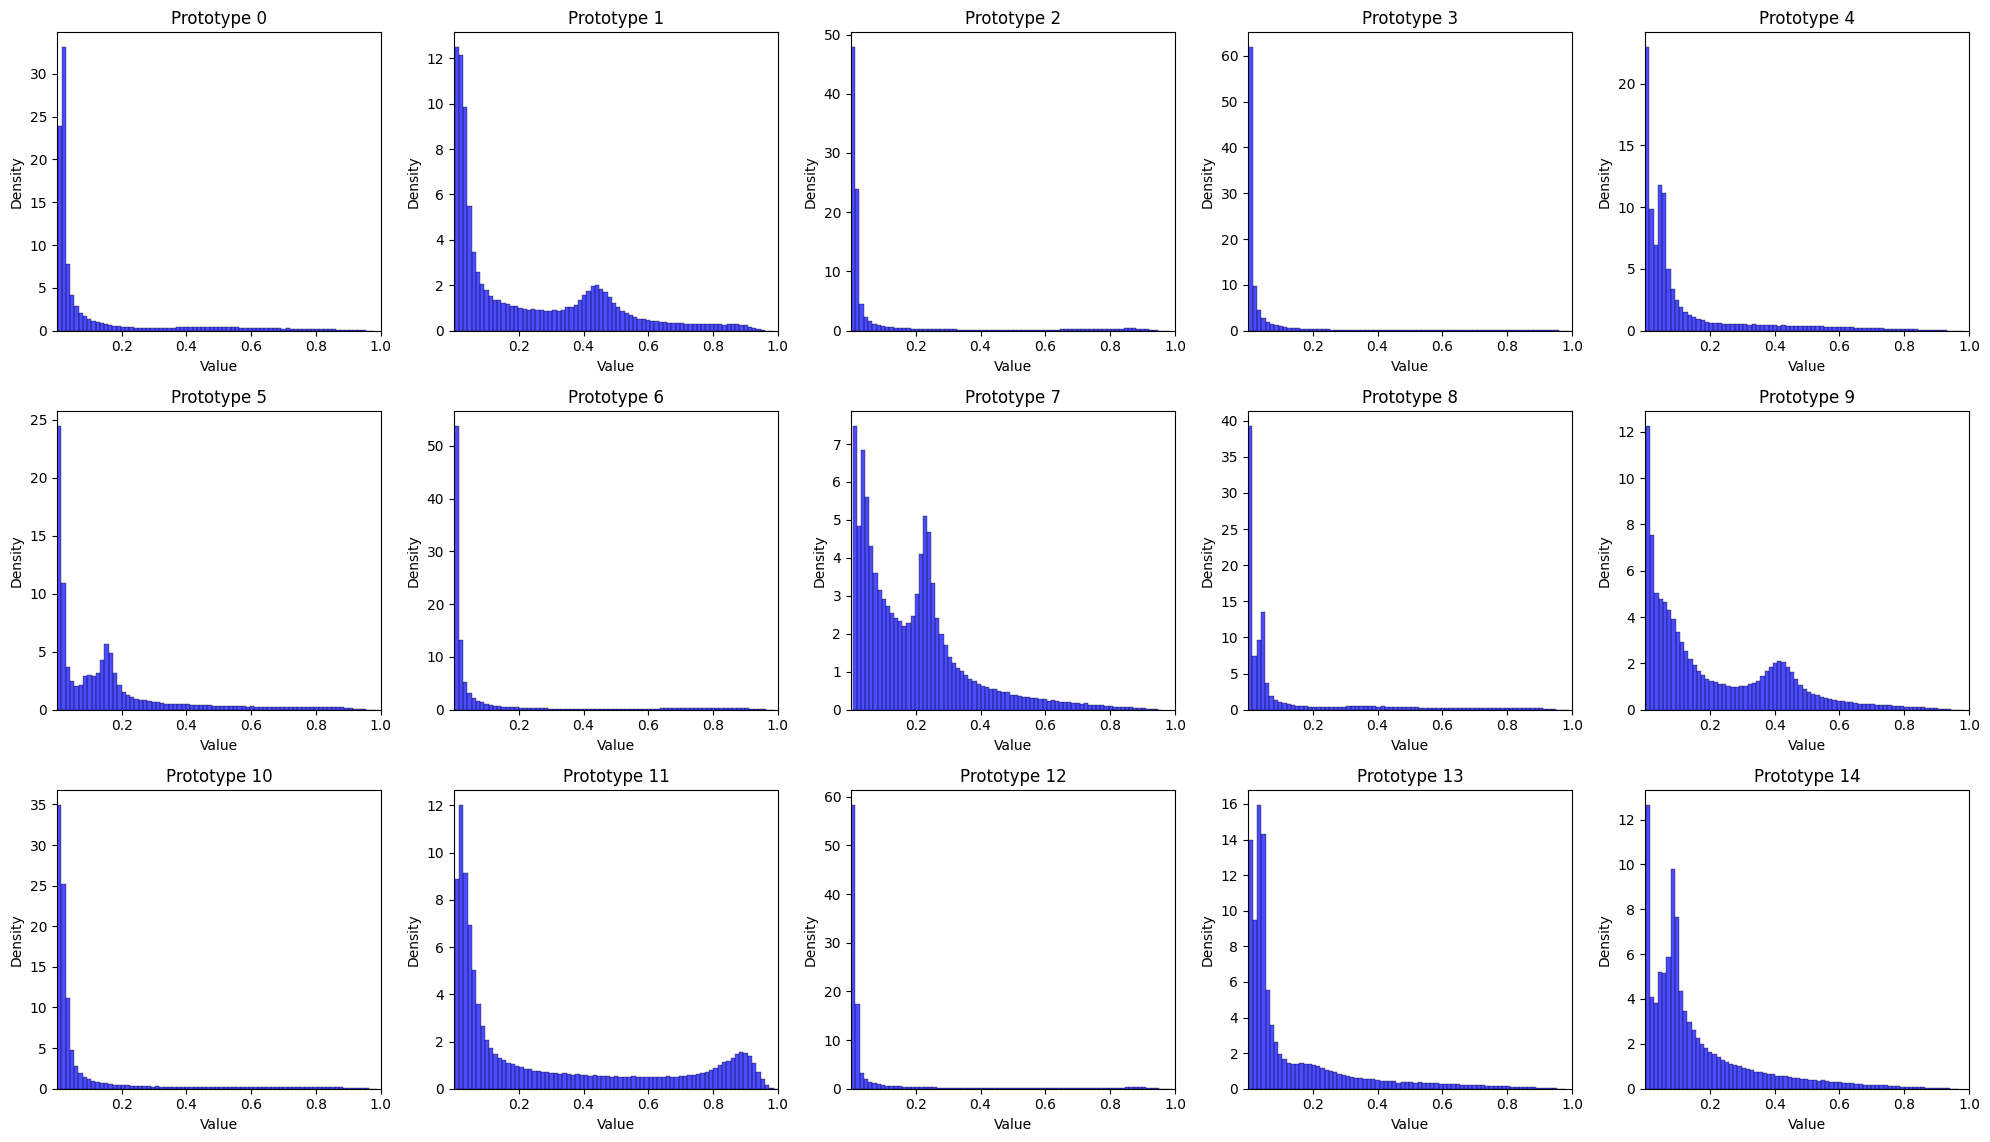

In [135]:
concepts_target = 1/(10000**n_distances)
plot_concepts_target_distributions(concepts_target, file_path="concept_labeling/shhs_to_mass/concept_inv10000.png")

Media per ciascuna prototipo: [0.12145755 0.22672633 0.07107733 0.09310993 0.12487842 0.16042678
 0.11050836 0.20110494 0.10922772 0.20864996 0.07053623 0.28078521
 0.05244879 0.1381769  0.16078749]
Deviazione standard per ciascuna colonna: [0.20478379 0.23784783 0.17104156 0.20864957 0.19600163 0.20693919
 0.22423275 0.17360326 0.20824067 0.19632829 0.14175375 0.30777895
 0.1307603  0.18167564 0.16321527]
Max per ciascuna colonna: [0.98410918 0.9774384  0.96321482 0.98550422 0.97101067 0.97465265
 1.         0.96516658 0.98162547 0.97066695 0.96321458 0.99758449
 0.97547939 0.96694901 0.93898964]
Min per ciascuna colonna: [0.00228685 0.00292023 0.00013917 0.0014259  0.0007357  0.00109178
 0.00177236 0.00680069 0.00030722 0.00529089 0.00030418 0.00383377
 0.0001     0.00266882 0.00220229]


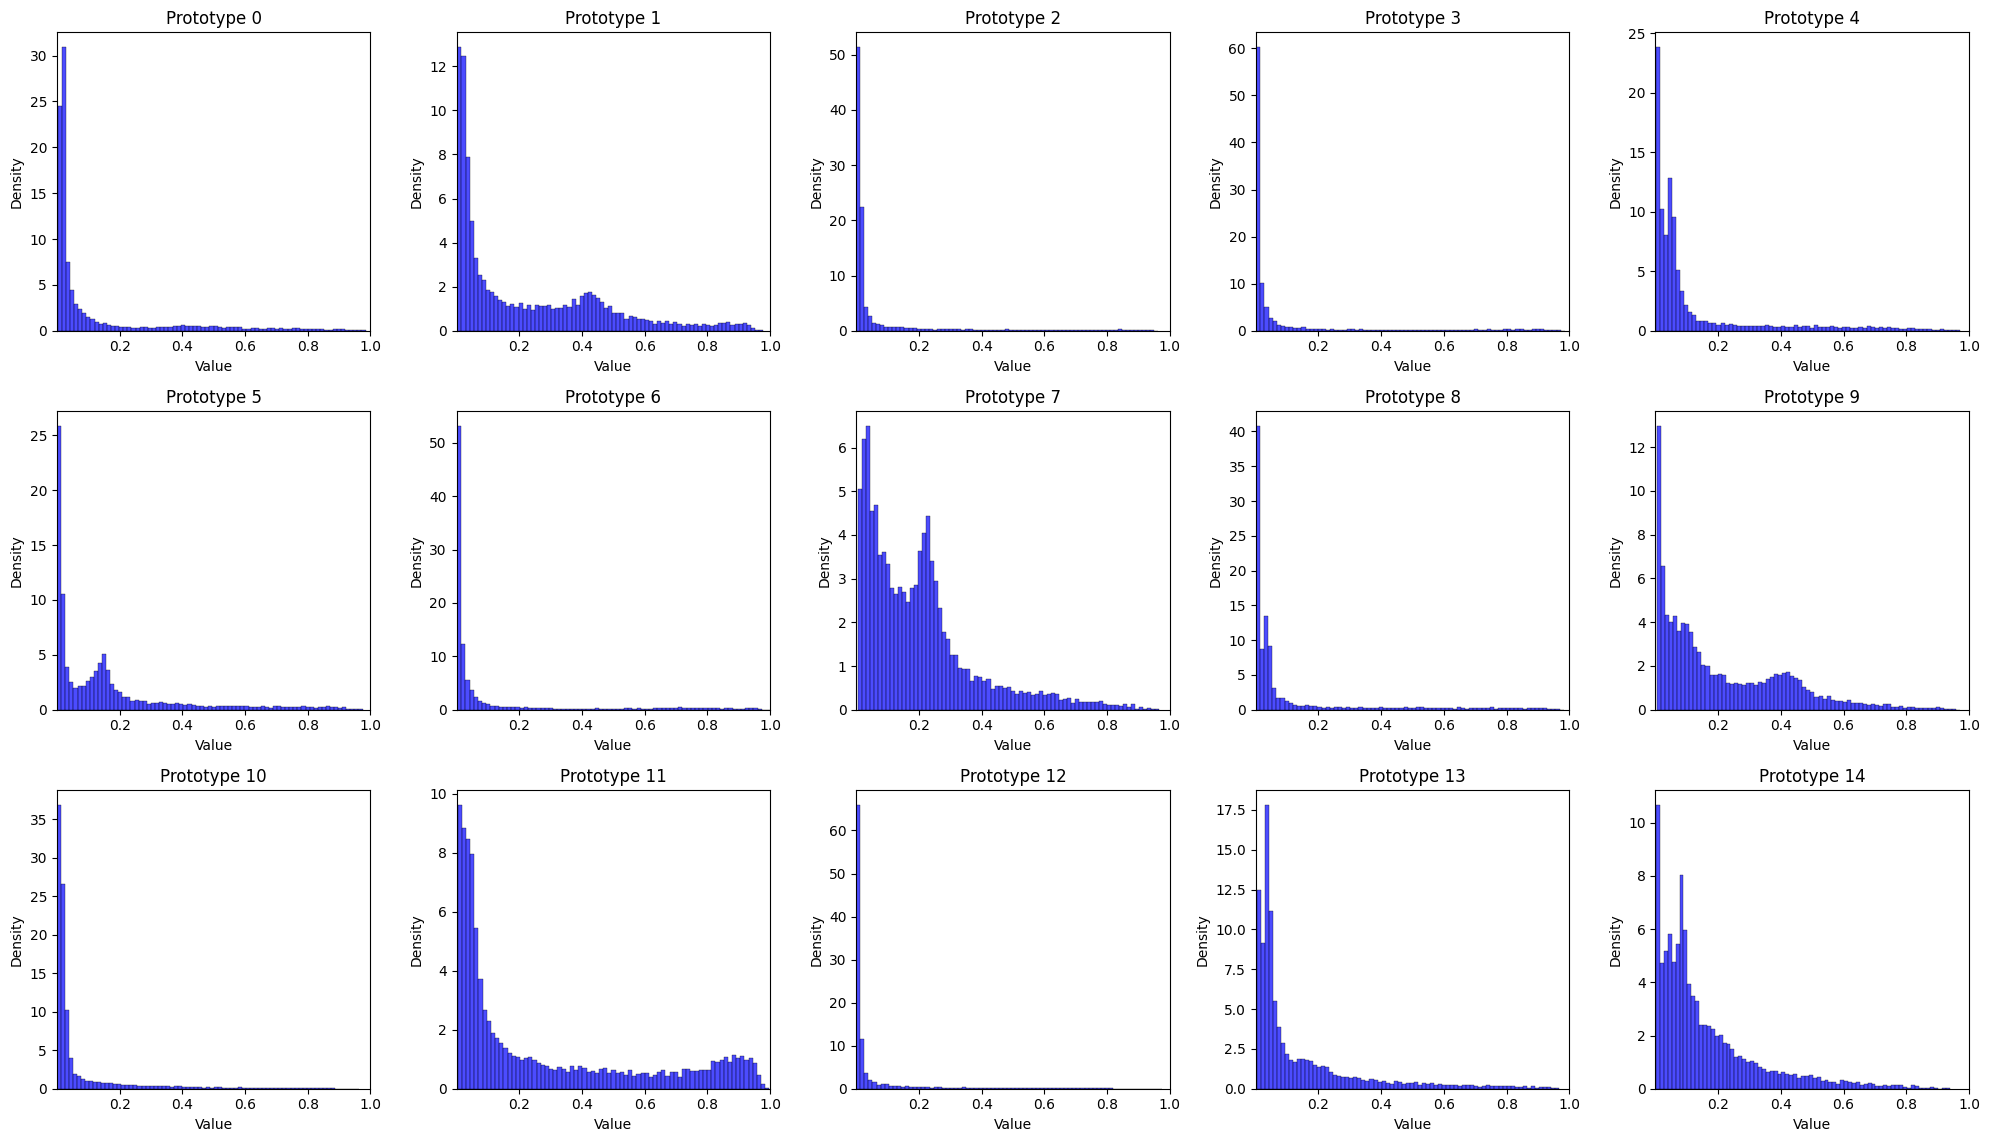

In [36]:
concepts_target = 1/(10000**n_distances)
plot_concepts_target_distributions(concepts_target,file_path="concept_labeling/shhs_to_mass")

Media per ciascuna prototipo: [0.17327533 0.37564206 0.09573287 0.12109677 0.17059871 0.24639061
 0.14253964 0.3529653  0.14668801 0.36067172 0.09848403 0.38830113
 0.07557385 0.20569294 0.25874138]
Deviazione standard per ciascuna colonna: [0.33530487 0.40521982 0.25885366 0.29526833 0.32380621 0.33445501
 0.31748483 0.33288944 0.31630742 0.37770596 0.2495937  0.42397237
 0.22604059 0.32246184 0.32251396]
Max per ciascuna colonna: [0.99005182 0.98984019 0.98936881 0.99009534 0.98963064 0.98975006
 0.99053314 0.98943517 0.9899737  0.98961927 0.9893688  0.99046198
 0.98977691 0.9894953  0.98849772]
Min per ciascuna colonna: [5.80473495e-07 1.24662303e-06 9.18644576e-11 1.32562535e-07
 1.67478913e-08 5.75329989e-08 2.61663436e-07 1.75191762e-05
 1.09217805e-09 7.99229577e-06 1.05877145e-09 2.91939656e-06
 3.26862600e-11 9.40810911e-07 5.15972550e-07]


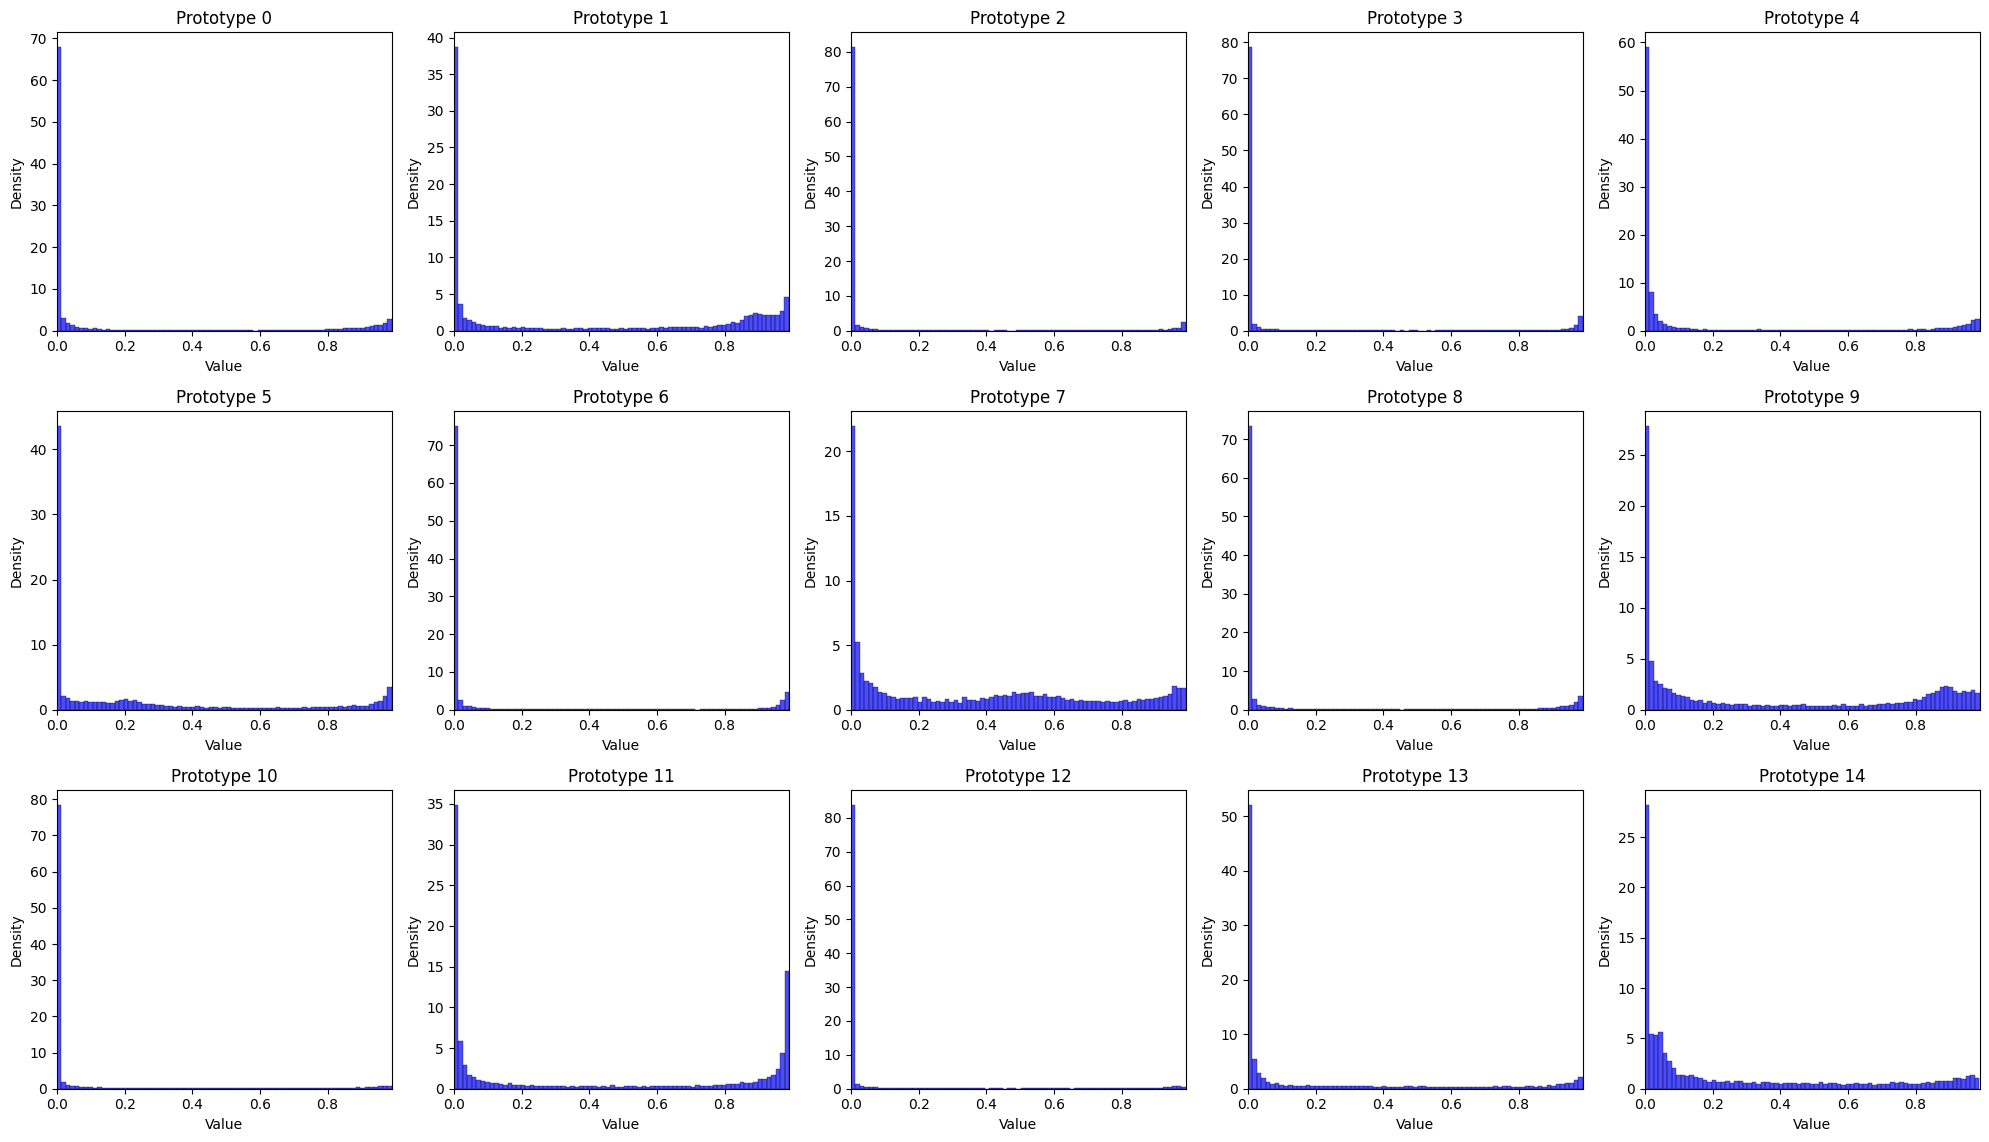

In [361]:
# concepts_target = 1/(1 + 5**(10*(distances-0.30))) #reverse sigmoid
# plot_concepts_target_distributions(concepts_target,file_path="concept_labeling/shhs_to_mass/concept_sigmoid.png")

In [122]:
# concepts_target = 1/(1 + 5**(10*(distances-0.30))) #reverse sigmoid
# plot_concepts_target_distributions(concepts_target, y_max=15 ,file_path="concept_labeling/shhs_to_mass/concept_sigmoid_zoom.png")

In [123]:
# concepts_target = 1/(1 + distances*(10000**distances))
# plot_concepts_target_distributions(concepts_target,file_path="concept_labeling/shhs_to_mass/concept_strana_zoom.png", y_max=10)

In [124]:
# concepts_target = 1/(1000**distances)
# plot_concepts_target_distributions(concepts_target, file_path="concept_labeling/shhs_to_mass/concept_inv1000_zoom.png", y_max=10)

In [15]:
len(concepts_target)

NameError: name 'concepts_target' is not defined

In [138]:
np.sum(concepts_target > 0.80)

80399

In [140]:
for i in range(15):
    print("concept:",i,"\tconcept act:", np.round(concepts_target[1000][i], 2))

concept: 0 	concept act: 0.0
concept: 1 	concept act: 0.06
concept: 2 	concept act: 0.76
concept: 3 	concept act: 0.0
concept: 4 	concept act: 0.0
concept: 5 	concept act: 0.16
concept: 6 	concept act: 0.0
concept: 7 	concept act: 0.01
concept: 8 	concept act: 0.59
concept: 9 	concept act: 0.01
concept: 10 	concept act: 0.0
concept: 11 	concept act: 0.02
concept: 12 	concept act: 0.56
concept: 13 	concept act: 0.0
concept: 14 	concept act: 0.0


In [141]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.patheffects as path_effects



palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])
palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])

from matplotlib.colors import LinearSegmentedColormap
colori_personalizzati =["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"]
# Creazione della colormap
colormap_personalizzata = LinearSegmentedColormap.from_list('nome_colormap', colori_personalizzati, N=5)

def plot_pca_2d(data, colors, percentage=1, additional_points=None, num_additional_points=False):
    # Perform PCA to reduce to 2 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]
    
    plt.figure(figsize=(10, 8))
    # Define a palette with 5 distinct colors
    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        if num_additional_points is False:
            sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)
        else:
            sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=10, marker='o', edgecolor='white', legend='full')
            for i, (x, y) in enumerate(zip(additional_points_2d[:, 0], additional_points_2d[:, 1])):
                plt.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', weight='bold',
                         path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
    plt.title('2D PCA of 32-dimensional data')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
    plt.legend(title='Color')
    plt.grid(True)

    #plt.savefig('pca_2d_white.png', dpi=300)
    
    plt.show()

def plot_pca_3d(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Plotting the results in 3D with color
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, cmap=colormap_personalizzata, alpha=0.8)
    #ax.set_title('3D PCA')
    ax.set_xlabel(f'PC 1 ({explained_variance[0]:.2f} variance)')
    ax.set_ylabel(f'PC 2 ({explained_variance[1]:.2f} variance)')
    ax.set_zlabel(f'PC 3 ({explained_variance[2]:.2f} variance)')
    #plt.colorbar(scatter, ax=ax, label='Color')
    plt.show()

def plot_pca_3d_i(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Create a DataFrame for Plotl
    df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Color': colors
    })
    # Plotting the results in 3D with color
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                        title='3D PCA of 32-dimensional data',
                        labels={'PC1': f'PC 1 ({explained_variance[0]:.2f} variance)',
                                'PC2': f'PC 2 ({explained_variance[1]:.2f} variance)',
                                'PC3': f'PC 3 ({explained_variance[2]:.2f} variance)'},
                        color_continuous_scale='Viridis')
    fig.update_layout(width=800,height=1000,)
    fig.update_traces(marker=dict(colorscale='Viridis'))
    fig.show()

def plot_tnse_2d(data, colors, percentage=1):
    # Applicare TSNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results_save = tsne.fit_transform(data)
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        tsne_results = tsne_results_save[random_indices]
        colors = colors[random_indices]

    

    # Visualizzare i risultati
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis", marker='o')
    plt.colorbar(ticks=range(5))
    plt.clim(-0.5, 2.5)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title('t-SNE visualization of Iris dataset')
    plt.show()

def plot_parcord(data, colors, percentage=1, eps = 0.00001):
    
    if (percentage<1):
            num_elements = int(len(data) * percentage)
            random_indices = np.random.choice(len(data), num_elements, replace=False)

            # Create new sampled arrays
            data = embeddings_array_ref[random_indices]
            colors = colors[random_indices]

    df = pd.DataFrame(data[:,:])
    df['phase'] = colors
    df.iloc[0, 32] = 0
    df.iloc[1, 32] = 1
    df.iloc[2, 32] = 2
    df.iloc[3, 32] = 3
    df.iloc[4, 32] = 4
    # Creare il Parallel Coordinates Plot
    for i in range(32):
        if (df[i].max() - df[i].min()) < eps:
            print("Non used feature: ", i)
            
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df, 'phase', colormap=colormap_personalizzata)
    #parallel_coordinates(df, df[0])
    plt.title('Parallel Coordinates')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.show()

def plot_silhouette_scores(data, n_clusters_range, percentage=1):
    silhouette_avgs = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = data[random_indices]

    for n_clusters in n_clusters_range:
        # Eseguire il clustering con K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcolare l'indice di silhouette medio
        if len(set(cluster_labels)) > 1:  # Assicurati che ci siano almeno due cluster
            silhouette_avg = silhouette_score(data, cluster_labels)
        else:
            silhouette_avg = -1  # Se c'è solo un cluster, silhouette score non è definito
        
        silhouette_avgs.append(silhouette_avg)
        print(f"Silhouette n={n_clusters} - {round(silhouette_avg, 3)}\\\\")

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=n_clusters_range, y=silhouette_avgs, marker='o')
    plt.title('Average Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.show()
    
def plot_KMeans_with_PCA(data, n_clusters, additional_points=None):
    # Eseguire il clustering con K-means
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)

    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_clustering_with_prototypes(data, additional_points, silhouette = False):
    # Controllo se ci sono punti aggiuntivi
    if additional_points is None or len(additional_points) == 0:
        raise ValueError("I punti aggiuntivi devono essere forniti come centroidi.")

    # Standardizzare i dati
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    additional_points_scaled = scaler.transform(additional_points)
    
    # Assegnare ciascun punto al centroide più vicino
    distances = cdist(data, additional_points_scaled, metric='euclidean')
    cluster_labels = np.argmin(distances, axis=1)
    
    if silhouette:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Coefficient: {silhouette_avg:.2f}")
        
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Ridurre la dimensionalità dei punti aggiuntivi
    additional_points_2d = pca.transform(additional_points_scaled)
    
    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')

    # Aggiungere i punti aggiuntivi come prototipi (centroidi)
    df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
    df_additional['Cluster'] = 'Prototype'
    sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full')
    
    plt.title('Cluster using prototypes as centroid - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_KMeans_with_tSNE(data, n_clusters):
    # Eseguire il clustering con K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Ridurre la dimensionalità a 2D per la visualizzazione usando t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['Dim1', 'Dim2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=50, marker='o', legend='full')
    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - t-SNE Projection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Cluster Label')
    plt.show()



In [142]:
df = pd.DataFrame(embeddings_array_ref)

Explained variance by component 1: 0.67
Explained variance by component 2: 0.24


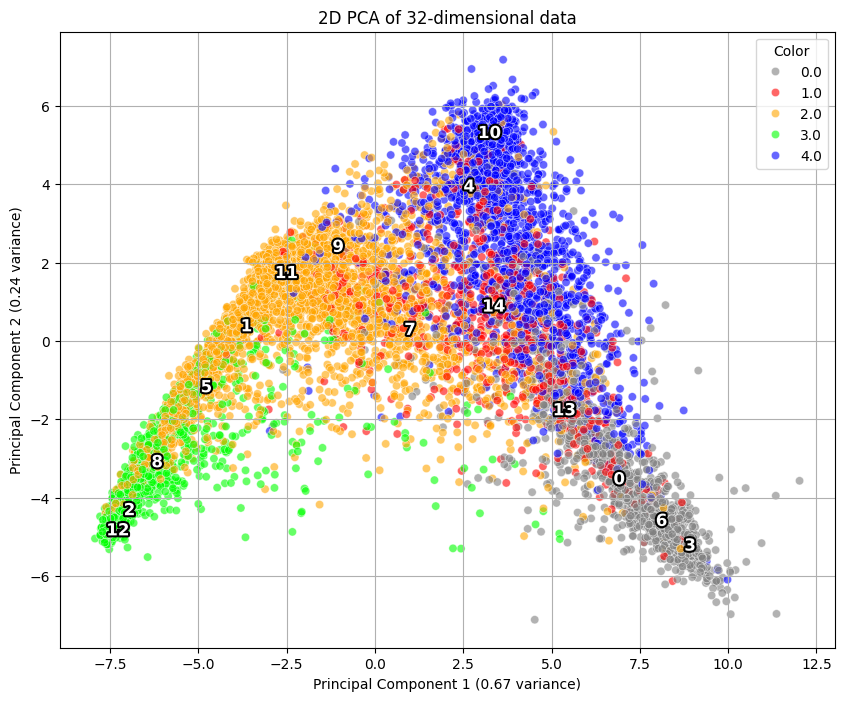

In [145]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, additional_points=prototypes[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]], num_additional_points=True, percentage=0.05)
#plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=0.7)

Explained variance by component 1: 0.69
Explained variance by component 2: 0.23


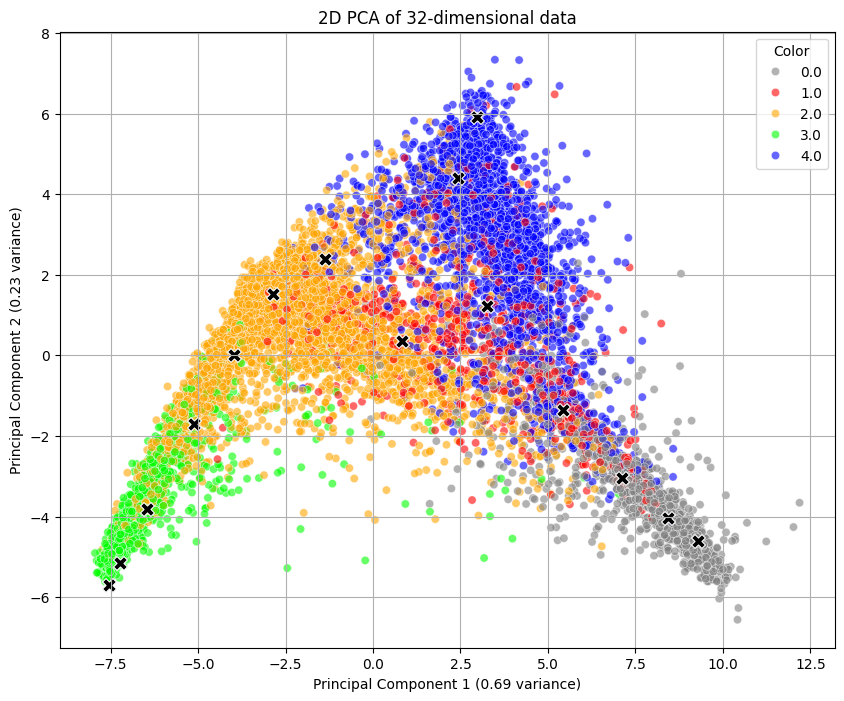

In [28]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, additional_points=prototypes, percentage=1)
#plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=0.7)

Explained variance by component 1: 0.36
Explained variance by component 2: 0.19
Explained variance by component 3: 0.13


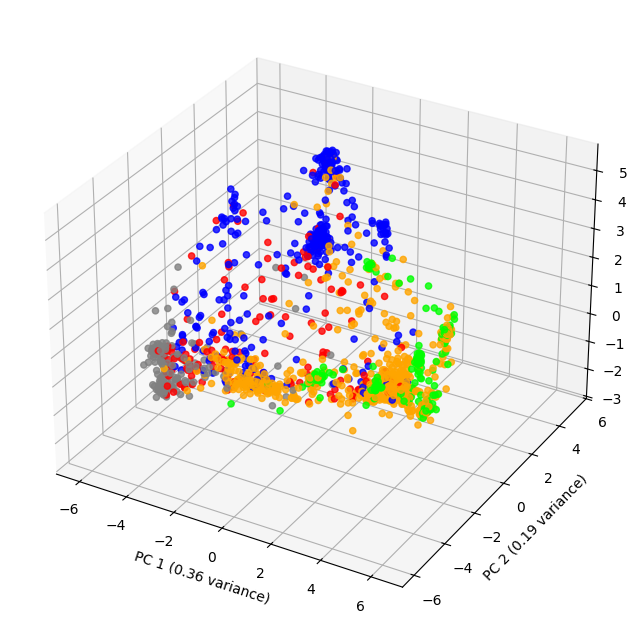

In [64]:
plot_pca_3d(embeddings_array_ref, labels_array_ref, percentage=0.2)

In [38]:
plot_pca_3d_i(embeddings_array_ref, labels_array_ref, percentage=0.5)

Explained variance by component 1: 0.57
Explained variance by component 2: 0.37
Explained variance by component 3: 0.02


## Prototype Freq-Ampl

In [16]:
dataset = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=batch_size,
    preprocessing=input_transform,
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=target_transform,
    data_folder = "/mnt/guido-data"
)

Selected fold for dataset 0: 0
Selected fold for dataset 0: 0


In [17]:
# compute the metrics on the test set
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
#dataloder = dataset.test_dataloader()
dataloder = dataset.train_dataloader()
#num = len(dataloder)*batch_size
emb_dim = 32

model = model2
print(checkpoint2)
prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()

NameError: name 'model2' is not defined

In [18]:
prototypes = model.nn.classifier.prototypes.cpu().detach().numpy()
L = model.nn.L
print("seq len:", L)
central_epoch = int((L - 1) / 2)
print("central_epoch", central_epoch, "\n\n")
print("proto shape", prototypes.shape)

p=20
continue_var = False
input_count = 0
closest_embeddings = {i: [0]*p for i in range(prototypes.shape[0])}
closest_distances = {i: [float('inf')]*p for i in range(prototypes.shape[0])}
print(closest_distances)

closest_corresponding_inputs = {i: [0]*p for i in range(prototypes.shape[0])}
closest_corresponding_labels = {i: [0]*p for i in range(prototypes.shape[0])}

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        # Ottieni gli embeddings per il batch
        embeddings = model.nn.encode(inputs.to(device)).permute(1, 0, 2)[central_epoch].cpu().detach().numpy()

        # Calcola la distanza euclidea tra prototipi ed embeddings
        for proto_index, proto in enumerate(prototypes):
            distances = np.linalg.norm(embeddings - proto, axis=1)
            # Trova i p embeddings più vicini attualmente salvati per questo prototipo

            max_distance_index = np.argmax(closest_distances[proto_index])
            max_distance = closest_distances[proto_index][max_distance_index]
            # Se troviamo una distanza minore della distanza massima salvata, aggiorniamo la lista
            for idx, distance in enumerate(distances):
                if distance < max_distance:
                    # Se l'input è già stato salvato, non aggiornare
                    for j in range(p):
                        if(distance == closest_distances[proto_index][j]):
                            input_count = input_count+1
                            print("input_count: ", input_count)
                            continue_var = True
                    if continue_var:
                        continue_var = False
                        continue

                    # Sostituisci il più lontano se la distanza è più piccola
                    closest_distances[proto_index][max_distance_index] = distance
                    closest_embeddings[proto_index][max_distance_index] = embeddings[idx]
                    closest_corresponding_inputs[proto_index][max_distance_index] = inputs[idx]
                    closest_corresponding_labels[proto_index][max_distance_index] = labels[idx]
                    # Aggiorna il massimo
                    max_distance_index = np.argmax(closest_distances[proto_index])
                    max_distance = closest_distances[proto_index][max_distance_index]
                    # Print per far vedere che entrano input identici
                    # if(proto_index == 0):
                    #     print(max_distance_index, " con ", max_distance, "| new dictances: ", closest_distances[proto_index])

        if i == len(dataloder) - 1:
            n_last_batch = inputs.size(0)
    
for key in closest_embeddings:
    closest_embeddings[key] = np.array(closest_embeddings[key])

AttributeError: 'dict' object has no attribute 'nn'

In [19]:
from collections import Counter
sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]

def labels_percentage(tensor_list):
    """
    Questa funzione prende una lista di tensori PyTorch e calcola la percentuale
    di occorrenza di ogni numero nella lista.
    
    Args:
    - tensor_list (list): Una lista di tensori PyTorch.
    
    Returns:
    - dict: Un dizionario con i numeri come chiavi e le loro percentuali come valori.
    """
    # Convertiamo la lista di tensori in una lista piatta di numeri
    flattened_list = torch.cat(tensor_list).tolist()

    # Conta le occorrenze di ciascun numero
    counts = Counter(flattened_list)

    # Calcola il totale dei numeri
    total_numbers = len(flattened_list)

    # Calcola la percentuale per ciascun numero
    percentages = {key: str(int((value / total_numbers) * 100))+"%" for key, value in counts.items()}
    percentages = {sleep_stages[key]: value for key, value in percentages.items()}

    return percentages

def process_dict_and_plot(data_dict, labels, denorm=None, cut = None, folder=None):
    """
    Questa funzione prende in input un dizionario con chiavi 0, 1, 2 ecc.,
    dove ogni valore è un tensore con shape [p, l_epoch, 1, T, F].
    La funzione somma i valori lungo l_epoch e T per ridurre il tensore a [p, F]
    e poi calcola la media e la deviazione standard per ogni proto.

    Args:
    - data_dict (dict): Dizionario con chiavi 0, 1, 2... contenente tensori con shape [p, l_epoch, 1, T, F]

    Returns:
    - None: Mostra i grafici per ogni proto
    """
    # Definisci i limiti delle bande cerebrali (in Hz)
    bands = {
        "Delta": (0, 4, 'blue'),
        "Theta": (4, 8, 'green'),
        "Alpha": (8, 12, 'yellow'),
        "Beta": (12, 32, 'orange'),
        "Gamma": (32, None, 'red')  # Gamma va oltre 32 Hz
    }

    for proto_idx, proto_tensor in data_dict.items():
        # Estrazione delle dimensioni dal tensore
        proto_tensor = np.stack(proto_tensor)

        if cut is not None:
            proto_tensor = proto_tensor[... , :cut]
        
        p_dim, l_epoch, _, T, F = proto_tensor.shape
        
        if(denorm is not None):
            mean, std = denorm
            mean = np.array(mean[..., :F])
            std = np.array(std[..., :F])
            proto_tensor = proto_tensor * std + mean
            proto_tensor = 2**(proto_tensor/20)

        # neg_values = proto_tensor[proto_tensor < 0].size
        # print("negative values: ", neg_values)
        
        # Somma lungo l_epoch e T per ottenere il tensore ridotto
        tensor_reduced = proto_tensor.sum(axis=(1, 3), keepdims=True)  # Shape diventa [p, 1, 1, 1, F]
        tensor_reduced = tensor_reduced[:, 0, 0, 0, :]  # Riduce ulteriormente a shape [p, F]
        
        # Calcolo della media e della deviazione standard lungo l'asse p
        mean_proto = np.mean(tensor_reduced, axis=0)  # Shape [F]
        std_proto = np.std(tensor_reduced, axis=0)    # Shape [F]
        
        # Generazione del grafico con seaborn
        frequencies = np.arange(F)  # Asse delle frequenze F
        
        labels_perc = labels_percentage(labels[proto_idx])
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=frequencies, y=mean_proto, label=f'Proto {proto_idx} - Mean')
        plt.fill_between(frequencies, mean_proto - std_proto, mean_proto + std_proto, color='b', alpha=0.2, label='Std Dev')

        string = (str(labels_perc)[1:-1]).replace("'", "")
        plt.title(f'Proto {proto_idx} | {string}')
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.legend()
        #plt.grid(True)
        
        #------------------legenda senza le bande cerebrali------------------
        # for band_name, (low_freq, high_freq, color) in bands.items():
        #     if high_freq is not None:
        #         plt.axvspan(low_freq, high_freq, color=color, alpha=0.1, label=band_name)
        #     else:
        #         plt.axvspan(low_freq, F, color=color, alpha=0.1, label=band_name)  # Gamma va fino alla fine

        #------------------legenda con le bande cerebrali------------------
        handles = []
        for band_name, (low_freq, high_freq, color) in bands.items():
            if high_freq is not None:
                band_patch = plt.Line2D([0], [0], color=color, lw=2)
                handles.append(band_patch)
                plt.axvspan(low_freq, high_freq, color=color, alpha=0.1)
            else:
                band_patch = plt.Line2D([0], [0], color=color, lw=2)
                handles.append(band_patch)
                plt.axvspan(low_freq, F, color=color, alpha=0.1)

        # Aggiungere la legenda personalizzata
        labels_bands = [f'{band_name} ({low_freq}-{high_freq if high_freq is not None else "end"})' for band_name, (low_freq, high_freq, color) in bands.items()]
        plt.legend(handles=handles + plt.gca().get_legend_handles_labels()[0], labels=labels_bands + plt.gca().get_legend_handles_labels()[1], loc='upper right')
        #--------------------------------------------------------------------
        if folder is not None:
            plt.savefig(f'protos/{folder}/proto_{proto_idx}.png', dpi=300)
        # Mostra il grafico
        plt.show()

def plot_all_protos_together(data_dict, labels, denorm=None, cut=None, folder=None):
    """
    Questa funzione genera una figura con 15 plot, ognuno corrispondente a un proto,
    e mantiene la stessa scala per l'asse delle y su tutti i plot.
    
    Args:
    - data_dict (dict): Dizionario con chiavi 0, 1, 2... contenente tensori con shape [p, l_epoch, 1, T, F]
    - labels (list): Lista di tensori corrispondenti alle etichette di ogni proto
    - denorm (tuple): Tuple (mean, std) per la denormalizzazione, opzionale
    - cut (int): Numero di feature da tagliare (opzionale)
    - folder (str): Cartella dove salvare le immagini (opzionale)
    
    Returns:
    - None: Mostra i grafici per tutti i proto insieme
    """
    # Definisci i limiti delle bande cerebrali (in Hz)
    bands = {
        "Delta": (0, 4, 'blue'),
        "Theta": (4, 8, 'green'),
        "Alpha": (8, 12, 'yellow'),
        "Beta": (12, 32, 'orange'),
        "Gamma": (32, None, 'red')  # Gamma va oltre 32 Hz
    }
    
    num_protos = len(data_dict)  # Numero di proto da plottare
    num_rows = 3  # Numero di righe nel layout della griglia
    num_cols = 5  # Numero di colonne nel layout della griglia
    
    # Crea la figura e una griglia di sottotrame
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    
    # Troviamo i limiti massimi e minimi per l'asse y per uniformare la scala
    y_min, y_max = float('inf'), float('-inf')
    
    # Prima passata: calcola i valori minimi e massimi
    for proto_idx, proto_tensor in data_dict.items():
        proto_tensor = np.stack(proto_tensor)

        if cut is not None:
            proto_tensor = proto_tensor[..., :cut]
        
        p_dim, l_epoch, _, T, F = proto_tensor.shape

        if denorm is not None:
            mean, std = denorm
            mean = np.array(mean[..., :F])
            std = np.array(std[..., :F])
            proto_tensor = proto_tensor * std + mean
            proto_tensor = 2**(proto_tensor/20)
        
        tensor_reduced = proto_tensor.sum(axis=(1, 3), keepdims=True)  # Shape diventa [p, 1, 1, 1, F]
        tensor_reduced = tensor_reduced[:, 0, 0, 0, :]  # Riduce ulteriormente a shape [p, F]
        
        mean_proto = np.mean(tensor_reduced, axis=0)  # Shape [F]
        std_proto = np.std(tensor_reduced, axis=0)    # Shape [F]
        
        y_min = min(y_min, (mean_proto - std_proto).min())
        y_max = max(y_max, (mean_proto + std_proto).max())
    
    print(y_min, y_max)
    y_min = 0
    # Seconda passata: plottiamo i grafici
    for proto_idx, (proto_tensor, ax) in enumerate(zip(data_dict.values(), axes.flat)):
        proto_tensor = np.stack(proto_tensor)

        if cut is not None:
            proto_tensor = proto_tensor[..., :cut]
        
        p_dim, l_epoch, _, T, F = proto_tensor.shape

        if denorm is not None:
            mean, std = denorm
            mean = np.array(mean[..., :F])
            std = np.array(std[..., :F])
            proto_tensor = proto_tensor * std + mean
            proto_tensor = 2**(proto_tensor/20)
        
        tensor_reduced = proto_tensor.sum(axis=(1, 3), keepdims=True)  # Shape diventa [p, 1, 1, 1, F]
        tensor_reduced = tensor_reduced[:, 0, 0, 0, :]  # Riduce ulteriormente a shape [p, F]
        
        mean_proto = np.mean(tensor_reduced, axis=0)  # Shape [F]
        std_proto = np.std(tensor_reduced, axis=0)    # Shape [F]
        
        frequencies = np.arange(F)  # Asse delle frequenze F
        labels_perc = labels_percentage(labels[proto_idx])

        string = (str(labels_perc)[1:-1]).replace("'", "")
        
        ax.plot(frequencies, mean_proto, label=f'Proto {proto_idx} - Mean')
        ax.fill_between(frequencies, mean_proto - std_proto, mean_proto + std_proto, color='b', alpha=0.2)
        
        # Imposta il titolo e le etichette
        ax.set_title(f'Proto {proto_idx} | {string}', fontsize=10)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Amplitude')

        # Imposta gli stessi limiti per l'asse y per uniformare la scala
        ax.set_ylim(y_min, y_max)

        # Aggiunge le bande cerebrali al grafico
        for band_name, (low_freq, high_freq, color) in bands.items():
            if high_freq is not None:
                ax.axvspan(low_freq, high_freq, color=color, alpha=0.1)
            else:
                ax.axvspan(low_freq, F, color=color, alpha=0.1)

    # Rimuovi eventuali assi vuoti
    for i in range(num_protos, num_rows * num_cols):
        fig.delaxes(axes.flat[i])

    # Regola il layout
    plt.tight_layout()

    if folder is not None:
        plt.savefig(folder, dpi=300)

    # Mostra la figura con tutti i plot
    plt.show()


In [20]:
plot_all_protos_together(closest_corresponding_inputs, closest_corresponding_labels, denorm=(scaling_mean, scaling_std), cut = 50)

NameError: name 'closest_corresponding_inputs' is not defined

## Check dataset

In [19]:
dataset_concept = PhysioExDataModule(
    datasets= ["mass"],
    versions = None,
    folds = -1,
    batch_size=128,
    preprocessing=input_transform,
    selected_channels=picks,
    sequence_length = sequence_length,
    target_transform=target_transform,
    data_folder = "/mnt/guido-data",
    path_concept_targets = "/home/manni/physioex/shhs_to_mass_inv10000_concept_targets.npy"
)

Selected fold for dataset 0: 0
Selected fold for dataset 0: 0
Selected fold for dataset 0: 0


In [20]:
dataloder_concept = dataset_concept.test_dataloader()

In [21]:
len(dataloder_concept)

84

In [22]:
for batch in dataloder_concept:
    inputs, labels = batch
    classes, concepts = labels
    print(inputs.shape)
    print(classes.shape)
    print(concepts.shape)

    break

torch.Size([128, 3, 1, 29, 129])
torch.Size([128, 3])
torch.Size([128, 15])


In [23]:
idx = 22

In [24]:
print(classes[idx])

tensor([0, 1, 1])


In [25]:
for i in range(15):
    print("concept:",i,"\tconcept act:", np.round(concepts[idx][i], 3))

concept: 0 	concept act: tensor(0.8970)
concept: 1 	concept act: tensor(0.0210)
concept: 2 	concept act: tensor(0.0040)
concept: 3 	concept act: tensor(0.3590)
concept: 4 	concept act: tensor(0.0230)
concept: 5 	concept act: tensor(0.0140)
concept: 6 	concept act: tensor(0.5230)
concept: 7 	concept act: tensor(0.0930)
concept: 8 	concept act: tensor(0.0070)
concept: 9 	concept act: tensor(0.0310)
concept: 10 	concept act: tensor(0.0110)
concept: 11 	concept act: tensor(0.0250)
concept: 12 	concept act: tensor(0.0030)
concept: 13 	concept act: tensor(0.4660)
concept: 14 	concept act: tensor(0.1160)


### Check Model

In [26]:
picks=["EEG"]
sequence_length = 3
ssn_cem = load_pretrained_model(
    name="seqsleepnet_cem",
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "cel",
    ckpt_path = get_single_file_path('models/seqsleepnet_cem/seqsleepnet_cem_mass_l3_eeg_c0_20mae'),
    extra_params = {}
).eval()

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'nn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nn'])`.


In [27]:
ssn = load_pretrained_model(
    name="seqsleepnet",
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=False,
    loss = "cel",
    ckpt_path = get_single_file_path('models/seqsleepnet/seqsleepnet_mass_l3_eeg'),
    extra_params = {}
).eval()

In [28]:
with torch.no_grad():
    for inputs, labels in dataloder_concept:
        pred = ssn_cem(inputs.to(device))
        labels_class, labels_concept = labels
        pred_concept, pred_class = pred

        print("true class: ", labels_class[0])

        print("true concepts: ", np.round(labels_concept[0]*100, 3))
        print("pred concepts: ", np.round(pred_concept[0, 1, :, 0].to("cpu")*100, 3))
        print("pred concepts: ", np.round(pred_concept[0, 0, :, 0].to("cpu")*100, 3))
        print("pred concepts: ", np.round(pred_concept[0, 2, :, 0].to("cpu")*100, 3))
        break

true class:  tensor([4, 4, 0])
true concepts:  tensor([ 5.4190,  2.8190,  0.1650,  2.3240, 39.4430,  1.1580,  3.2520, 14.6470,
         0.3520, 12.4070, 18.3730,  5.7310,  0.1210, 12.6060, 41.3160])
pred concepts:  tensor([5.0880e+00, 3.2540e+00, 2.0200e-01, 2.2420e+00, 4.0225e+01, 1.1070e+00,
        3.1280e+00, 1.5257e+01, 4.6500e-01, 1.2964e+01, 1.9353e+01, 6.4120e+00,
        3.7000e-02, 1.1384e+01, 4.2975e+01])
pred concepts:  tensor([ 8.7730,  4.2500,  0.2760,  8.0360, 25.1180,  1.3550, 10.4040, 20.6240,
         0.9870, 14.7970, 14.4760,  9.9300,  0.0570, 21.0050, 35.3480])
pred concepts:  tensor([45.0500,  1.5920,  0.1260, 40.0260,  3.6640,  1.5460, 47.6630,  8.7400,
         1.5000,  3.5340,  5.7260,  4.3940,  0.3120, 38.2590,  9.8140])


### emb ssn-cem

In [29]:
dataloder_concept = dataset_concept.test_dataloader()

In [30]:
batch_size = 128
num = len(dataloder_concept)*batch_size
emb_dim = 128
con_emb_dim = 30

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]

L = 3
central_epoch = int((L - 1) / 2)
print("L: ", L, "\tcentral_epoch: ", central_epoch)

L:  3 	central_epoch:  1


In [31]:
import torch.nn.functional as F

embeddings_array = np.empty((num, emb_dim))
concepts_array = np.empty((num))
mse_array = np.empty((num, 15))
labels_array = np.empty((num))
con_emb_array = np.empty((num, con_emb_dim))

print(embeddings_array.shape)
print(labels_array.shape)

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder_concept), total=len(dataloder_concept)):
        #print(sleep_stages[labels[batch].item()])
        labels_class, labels_concept = labels

        embedding, pred = ssn_cem.encode(inputs.to(device))
        emb, con_emb = embedding
        pred_concept, pred_class = pred
        con_emb = con_emb.permute(1, 0, 2)[central_epoch].cpu().numpy()
        # embedding, _ = ssn.encode(inputs.to(device))
        # emb = embedding

        mse = (labels_concept.to(device) - pred_concept[:, central_epoch, :, 0]) ** 2
        concept_argmax = torch.argmax(labels_concept, dim=1).cpu().numpy()

        emb = emb.permute(1, 0, 2)
        embeddings_array[i*batch_size : i*batch_size+inputs.size(0)] = emb[central_epoch].cpu().numpy()
        labels_array[i*batch_size : i*batch_size+inputs.size(0)] = labels_class[:, central_epoch].cpu().numpy()
        concepts_array[i*batch_size : i*batch_size+inputs.size(0)] = concept_argmax
        con_emb_array[i*batch_size : i*batch_size+inputs.size(0)] = con_emb
        mse_array[i*batch_size : i*batch_size+inputs.size(0)] = mse.cpu().numpy()
        
        if i == len(dataloder_concept)-1:
            n_last_batch = inputs.size(0)


(10752, 128)
(10752,)


100%|██████████| 84/84 [00:01<00:00, 60.39it/s]


In [32]:
first_empty_element = len(embeddings_array)-batch_size+n_last_batch
embeddings_array_ref = embeddings_array[0:first_empty_element]
labels_array_ref = labels_array[0:first_empty_element]
concepts_array_ref = concepts_array[0:first_empty_element]
con_emb_array_ref = con_emb_array[0:first_empty_element]
mse_array_ref = mse_array[0:first_empty_element]

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.patheffects as path_effects

concept_palette = [
  "#C0C0C0",  #// 0: Grigio chiaro
  "#CCCC00",  #// 1: Giallo Scuro
  "#009900",  #// 2: Verde scuro
  "#606060",  #// 3: Grigio standard
  "#1E90FF",  #// 4: Azzurro
  "#A2C523",  #// 5: Verde oliva chiaro
  "#909090",  #// 6: Grigio medio
  "#FF4500",  #// 7: Rosso arancio intenso
  "#00FF00",  #// 8: Verde brillante
  "#FF6347",  #// 9: Rosso arancio (tra arancione e blu)
  "#0000FF",  #// 10: Blu puro
  "#FFA500",  #// 11: Arancione
  "#66FF66",  #// 12: Verde chiaro
  "#DDA0DD",  #// 13: Viola pallido
  "#8A2BE2"   #// 14: Blu violetto
]
palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])

from matplotlib.colors import LinearSegmentedColormap
colori_personalizzati =["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"]
# Creazione della colormap
colormap_personalizzata = LinearSegmentedColormap.from_list('nome_colormap', colori_personalizzati, N=5)

def plot_pca_2d(data, colors, percentage=1, additional_points=None, num_additional_points=False, p_palette=None):
    # Perform PCA to reduce to 2 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]
    
    plt.figure(figsize=(10, 8))
    
    # Define a palette 
    if p_palette is not None:
        palette = p_palette
    else:
        palette = sns.color_palette(["#808080","#FF0000","#FFA500","#00FF00", "#0000FF"])

    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        if num_additional_points is False:
            sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)
        else:
            sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=10, marker='o', edgecolor='white', legend='full')
            for i, (x, y) in enumerate(zip(additional_points_2d[:, 0], additional_points_2d[:, 1])):
                plt.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', weight='bold',
                         path_effects=[path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
    plt.title('2D PCA of 32-dimensional data')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
    plt.legend(title='Color')
    plt.grid(True)

    #plt.savefig('pca_2d_white.png', dpi=300)
    
    plt.show()

def plot_pca_3d(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Plotting the results in 3D with color
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, cmap=colormap_personalizzata, alpha=0.8)
    #ax.set_title('3D PCA')
    ax.set_xlabel(f'PC 1 ({explained_variance[0]:.2f} variance)')
    ax.set_ylabel(f'PC 2 ({explained_variance[1]:.2f} variance)')
    ax.set_zlabel(f'PC 3 ({explained_variance[2]:.2f} variance)')
    #plt.colorbar(scatter, ax=ax, label='Color')
    plt.show()

def plot_pca_3d_i(data, colors, percentage=1):
    # Perform PCA to reduce to 3 components
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    
    # Print the explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by component 1: {explained_variance[0]:.2f}")
    print(f"Explained variance by component 2: {explained_variance[1]:.2f}")
    print(f"Explained variance by component 3: {explained_variance[2]:.2f}")
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        pca_result = pca_result[random_indices]
        colors = colors[random_indices]

    # Create a DataFrame for Plotl
    df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Color': colors
    })
    # Plotting the results in 3D with color
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                        title='3D PCA of 32-dimensional data',
                        labels={'PC1': f'PC 1 ({explained_variance[0]:.2f} variance)',
                                'PC2': f'PC 2 ({explained_variance[1]:.2f} variance)',
                                'PC3': f'PC 3 ({explained_variance[2]:.2f} variance)'},
                        color_continuous_scale='Viridis')
    fig.update_layout(width=800,height=1000,)
    fig.update_traces(marker=dict(colorscale='Viridis'))
    fig.show()

def plot_tnse_2d(data, colors, percentage=1):
    # Applicare TSNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results_save = tsne.fit_transform(data)
    
    # Sample a percentage of the data
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        tsne_results = tsne_results_save[random_indices]
        colors = colors[random_indices]

    

    # Visualizzare i risultati
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis", marker='o')
    plt.colorbar(ticks=range(5))
    plt.clim(-0.5, 2.5)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title('t-SNE visualization of Iris dataset')
    plt.show()

def plot_parcord(data, colors, percentage=1, eps = 0.00001):
    
    if (percentage<1):
            num_elements = int(len(data) * percentage)
            random_indices = np.random.choice(len(data), num_elements, replace=False)

            # Create new sampled arrays
            data = embeddings_array_ref[random_indices]
            colors = colors[random_indices]

    df = pd.DataFrame(data[:,:])
    df['phase'] = colors
    df.iloc[0, 32] = 0
    df.iloc[1, 32] = 1
    df.iloc[2, 32] = 2
    df.iloc[3, 32] = 3
    df.iloc[4, 32] = 4
    # Creare il Parallel Coordinates Plot
    for i in range(32):
        if (df[i].max() - df[i].min()) < eps:
            print("Non used feature: ", i)
            
    plt.figure(figsize=(10, 6))
    parallel_coordinates(df, 'phase', colormap=colormap_personalizzata)
    #parallel_coordinates(df, df[0])
    plt.title('Parallel Coordinates')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.show()

def plot_silhouette_scores(data, n_clusters_range, percentage=1):
    silhouette_avgs = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    if (percentage<1):
        num_elements = int(len(data) * percentage)
        random_indices = np.random.choice(len(data), num_elements, replace=False)

        # Create new sampled arrays
        data = data[random_indices]

    for n_clusters in n_clusters_range:
        # Eseguire il clustering con K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcolare l'indice di silhouette medio
        if len(set(cluster_labels)) > 1:  # Assicurati che ci siano almeno due cluster
            silhouette_avg = silhouette_score(data, cluster_labels)
        else:
            silhouette_avg = -1  # Se c'è solo un cluster, silhouette score non è definito
        
        silhouette_avgs.append(silhouette_avg)
        print(f"Silhouette n={n_clusters} - {round(silhouette_avg, 3)}\\\\")

    # Creare il grafico
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=n_clusters_range, y=silhouette_avgs, marker='o')
    plt.title('Average Silhouette Score for Different Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.show()
    
def plot_KMeans_with_PCA(data, n_clusters, additional_points=None):
    # Eseguire il clustering con K-means
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')
    #protopyes
    if additional_points is not None:
        additional_points_scaled = scaler.transform(additional_points)
        additional_points_2d = pca.transform(additional_points_scaled)
        df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
        df_additional['Cluster'] = 'Prototype'
        sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full',)

    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_clustering_with_prototypes(data, additional_points, silhouette = False):
    # Controllo se ci sono punti aggiuntivi
    if additional_points is None or len(additional_points) == 0:
        raise ValueError("I punti aggiuntivi devono essere forniti come centroidi.")

    # Standardizzare i dati
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    additional_points_scaled = scaler.transform(additional_points)
    
    # Assegnare ciascun punto al centroide più vicino
    distances = cdist(data, additional_points_scaled, metric='euclidean')
    cluster_labels = np.argmin(distances, axis=1)
    
    if silhouette:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Coefficient: {silhouette_avg:.2f}")
        
    # Ridurre la dimensionalità a 2D per la visualizzazione usando PCA
    pca_comp = 2
    pca = PCA(n_components=pca_comp)
    data_2d = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    for i in range(pca_comp):
        print(f"Explained variance by component {i+1}: {explained_variance[i]:.2f}")   
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels

    # Ridurre la dimensionalità dei punti aggiuntivi
    additional_points_2d = pca.transform(additional_points_scaled)
    
    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab20', s=50, marker='o', legend='full')

    # Aggiungere i punti aggiuntivi come prototipi (centroidi)
    df_additional = pd.DataFrame(additional_points_2d, columns=['PC1', 'PC2'])
    df_additional['Cluster'] = 'Prototype'
    sns.scatterplot(data=df_additional, x='PC1', y='PC2', color='black', s=100, marker='X', edgecolor='white', legend='full')
    
    plt.title('Cluster using prototypes as centroid - PCA Projection')
    plt.xlabel(f'PC 1 ({explained_variance[0]:.2f} explained variance)')
    plt.ylabel(f'PC 2 ({explained_variance[1]:.2f} explained variance)')
    plt.legend(title='Cluster Label')
    plt.show()

def plot_KMeans_with_tSNE(data, n_clusters):
    # Eseguire il clustering con K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Ridurre la dimensionalità a 2D per la visualizzazione usando t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)
    
    # Creare un DataFrame per Seaborn
    df = pd.DataFrame(data_2d, columns=['Dim1', 'Dim2'])
    df['Cluster'] = cluster_labels

    # Plot dei cluster usando Seaborn
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=50, marker='o', legend='full')
    plt.title(f'Cluster K-means (n_clusters = {n_clusters}) - t-SNE Projection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Cluster Label')
    plt.show()



In [34]:
df = pd.DataFrame(embeddings_array_ref)

Explained variance by component 1: 0.24
Explained variance by component 2: 0.17


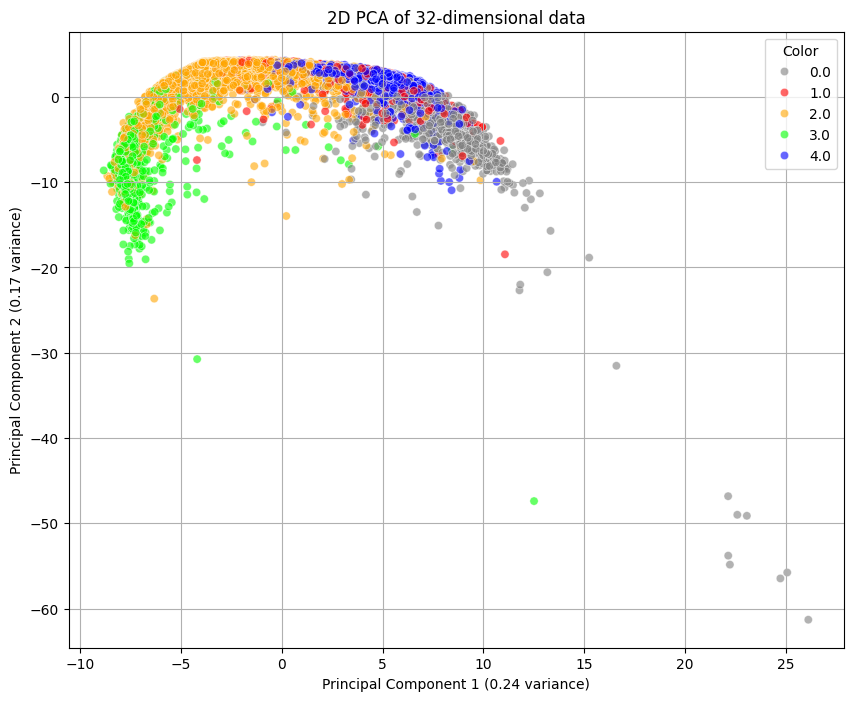

In [35]:
plot_pca_2d(embeddings_array_ref, labels_array_ref, percentage=1)

Explained variance by component 1: 0.36
Explained variance by component 2: 0.20


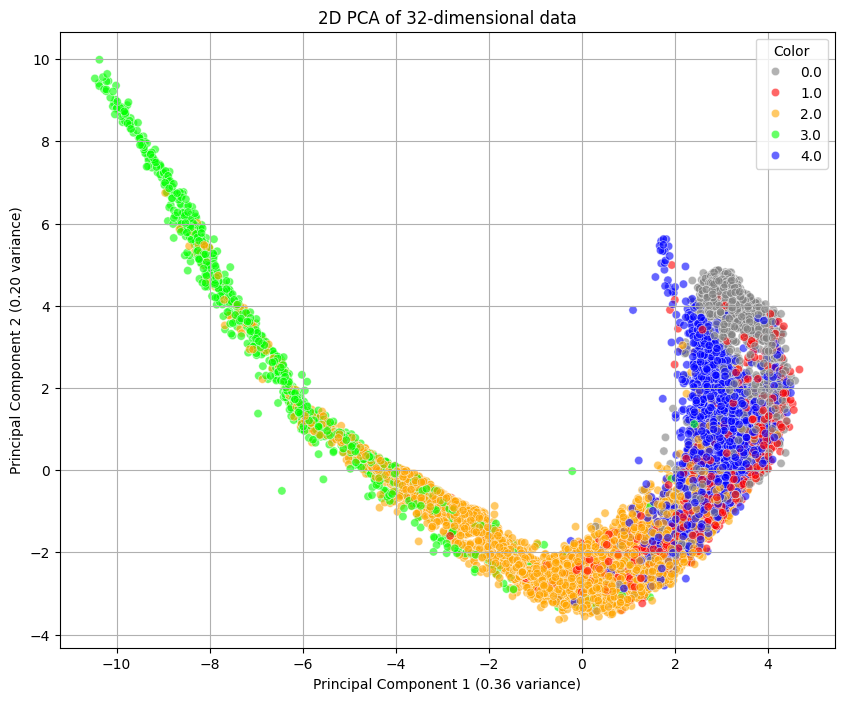

In [36]:
plot_pca_2d(con_emb_array_ref, labels_array_ref, percentage=1)

Explained variance by component 1: 0.36
Explained variance by component 2: 0.20


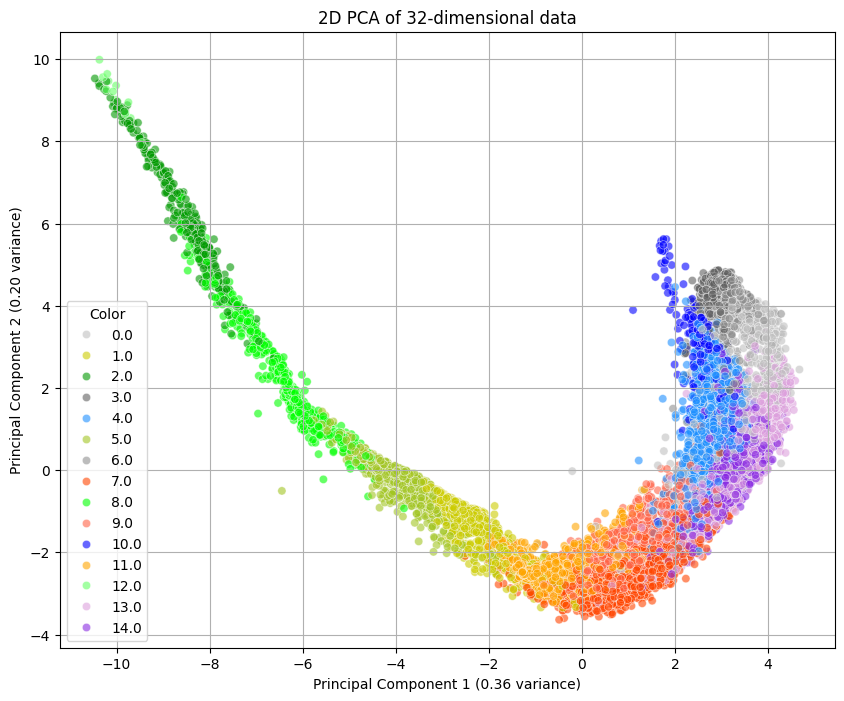

In [37]:
plot_pca_2d(con_emb_array_ref, concepts_array_ref, p_palette=concept_palette,percentage=1)

Explained variance by component 1: 0.24
Explained variance by component 2: 0.17


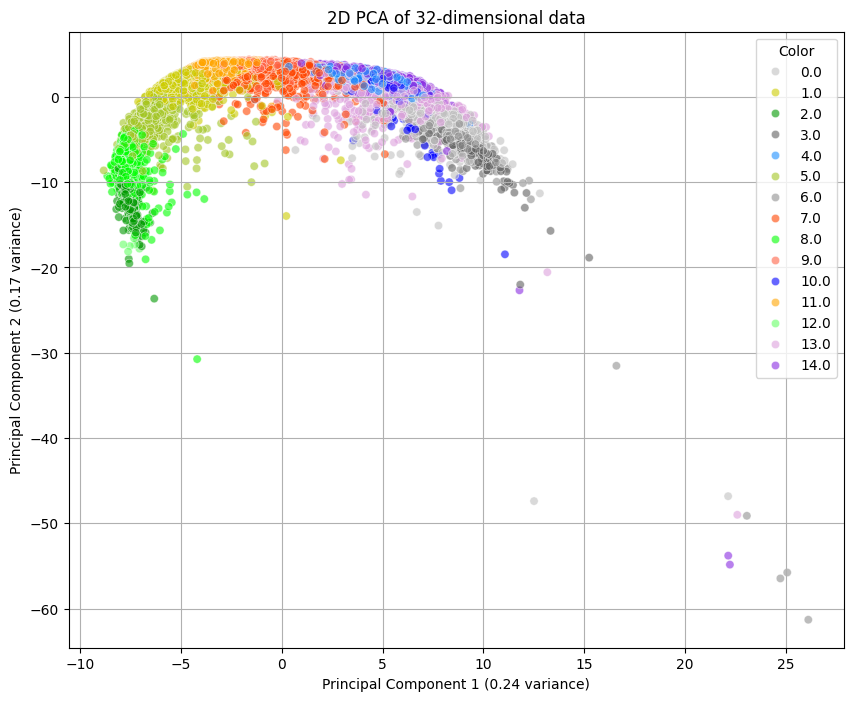

In [38]:
plot_pca_2d(embeddings_array_ref, concepts_array_ref, p_palette=concept_palette,percentage=1)

In [83]:
len(mse_array_ref)*15

160950

In [84]:
(mse_array_ref>= 0.03).sum()

3677

In [85]:
len(mse_array_ref)*15

160950

In [67]:
mse_array_ref.mean()

0.0028056155612021672

In [68]:
mse_array_ref.std()

0.011911307250909149

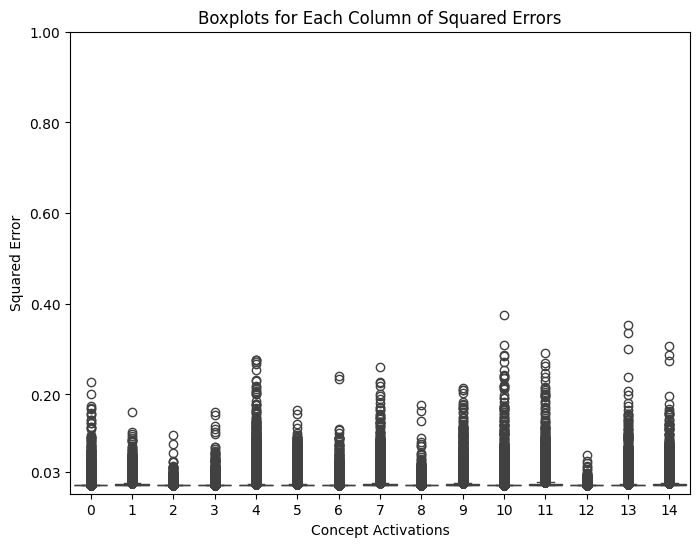

In [86]:
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
sns.boxplot(data=mse_array_ref)

# Label the plot
plt.title('Boxplots for Each Column of Squared Errors')
plt.xlabel('Concept Activations')
plt.ylabel('Squared Error')
plt.yticks([0.03, 0.2,  0.4, 0.6, 0.8, 1])  # Adjust the step as necessary
#plt.ylim(0, 0.4)  # Limit the y-axis to better see the boxplots

# Show the plot
plt.show()

In [70]:
silhouette_score(con_emb_array_ref, labels_array_ref)

0.22614654413568502

In [187]:
silhouette_score(con_emb_array_ref, concepts_array_ref)

-0.042536749717885035

Explained variance by component 1: 0.36
Explained variance by component 2: 0.20


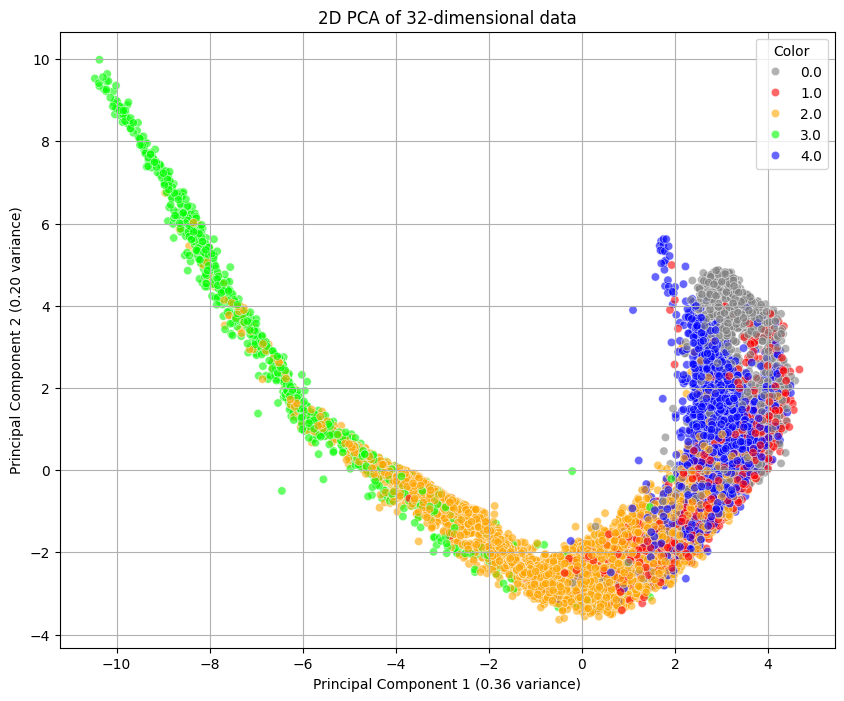

In [87]:
plot_pca_2d(con_emb_array_ref, labels_array_ref, percentage=1)

In [52]:
plot_pca_3d_i(con_emb_array_ref, labels_array_ref, percentage=0.5)

Explained variance by component 1: 0.37
Explained variance by component 2: 0.30
Explained variance by component 3: 0.10
